![Title slide](title_class-n.png)

### Libraries

In [ ]:
import pandas as pd
import os 
import numpy as np
import datetime
import missingno as msno
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay, 
    roc_curve, 
    auc, 
    precision_recall_curve, 
    RocCurveDisplay, 
    PrecisionRecallDisplay
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import export_text

# !pip install tensorflow
# !pip install keras-tuner
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.utils import class_weight as sk_class_weight
from tensorflow.keras.metrics import AUC, Precision, Recall
import keras_tuner as kt

### 1. Introduction: Variables description and modification

**Motivation** <br>
Attitudes toward gender roles and protection norms remain a central topic in contemporary social science, as they reflect deeper beliefs about equality, autonomy, and power relations between men and women. The statement “Women should be protected by men” captures a traditional perspective that may coexist with, or conflict with, modern views on gender equality. Understanding which psychosocial factors are associated with agreement or disagreement with this statement provides valuable insight into how such attitudes are structured across populations. <br>
From a methodological perspective, this problem is well-suited to a machine learning classification approach. While classical statistical models often focus on estimating average effects of individual predictors, machine learning models can capture complex, nonlinear relationships and interactions between multiple psychosocial variables. This makes them particularly useful for studying attitudes that are shaped by a combination of demographic, cultural, and psychological factors. <br>

**Research question:** <br>
Can a machine learning classification model reliably distinguish between individuals who agree and disagree with the statement “Women should be protected by men” using a concise set of psychosocial predictors? <br>	

The analysis is based on data from the European Social Survey (ESS) Round 11 [1], a large-scale, cross-national dataset widely used in academic research. The final dataset consists of **40,156** observations and **21 selected features**, chosen by the our team to balance interpretability and predictive power. The target variable is **"wprtbym"**, women should be protected by men (agree/disagree).

#### 1.1. Variables description

In [2]:
data = pd.read_csv('ESS11 - ML 2.csv')
print(data.head(5))

  cntry  happy  sclmeet  aesfdrk  health  rlgblg  rlgatnd  dscrgnd  likrisk  \
0    AT      8        4        2       3       1        6        0        2   
1    AT      9        7        3       2       2        7        0        0   
2    AT      9        4        3       1       2        5        1        0   
3    AT      7        6        3       3       1        6        0        0   
4    AT      9        5        1       2       1        7        0        1   

   mascfel  ...  impbemw  wprtbym  gndr  yrbrn  marsts  chldhhe  domicil  \
0        4  ...        3        2     1   1958      66        1        3   
1        3  ...        3        2     2   2002       6        2        1   
2        0  ...        5        4     2   1970      66        6        3   
3        0  ...        5        3     2   1945       4        1        1   
4        0  ...        5        3     1   1959      66        1        4   

   edulvlb  pdwrk  wkhtot  
0      322      0     666  
1      423  

**Rationale for variable selection** <br>
The selected variables were chosen to capture a broad range of psychosocial, demographic, cultural, and contextual factors that usually are closely related to attitudes toward gender roles and protection norms. In particular, the statement “Women should be protected by men” reflects not only individual beliefs but also deeper socialization processes, cultural backgrounds, and personal experiences. The variables can be grouped into several conceptually motivated categories.

1. Cultural and contextual background <br>
- **cntry** - Country. Country codes. <br>
- **domicil** - Domicile, respondent's description. <br>
[1 - A big city, 2 - Suburbs or outskirts of big city, 3 - Town or small city, 4 - Country village, 5 - Farm or home in countryside, 7 - Refusal*, 8 - Don't know*, 9 - No answer*, * - Missing value] <br>
- **aesfdrk** - Feeling of safety walking alone after dark. <br>
[1 - Very safe, 2 - Safe, 3 - Unsafe, 4 - Very unsafe, 7 - Refusal*, 8 - Don't know*, 9 - No answer*, * - Missing value] <br>
- **yrbrn** - Year of birth. <br>
[7777 - Refusal*, 8888 - Don't know*, 9999 - No answer*, * - Missing value ] <br>
- **dscrgnd** - Has experienced gender discrimination. On what grounds is your group discriminated against? <br>
[0 - Not marked, 1 - Marked,* - Missing value] <br>
- **likrisk** - I like to take risks, to what extent. <br>
[0 - Not at all, 6 - Completely, 7 - Refusal*, 8 - Don't know*, 9 - No answer*, * - Missing value]<br>


2. Subjective well-being and social integration
- **happy** - How happy are you. <br>
[0 - Extremely unhappy, 10 - Extremely happy, 77 - Refusal, 88 - Don't know*, 99 - No answer*, * - Missing value ]<br>
- **sclmeet** - How often socially meet with friends, relatives, or colleagues. <br>
[1 - Never, 2 - Less than once a month, 3 - Once a month, 4 - Several times a month, 5 - Once a week, 6 - Several times a week ,7 - Every day, 77 - Refusal*, 88 - Don't know*, 99 - No answer*, * - Missing value] <br>
- **health** - Subjective general health. <br>
[1 - Very good, 2 - Good, 3 - Fair, 4 - Bad, 5 - Very bad, 7 - Refusal*, 8 - Don't know*, 9 - No answer*, * - Missing value] <br>


3. Religion and value systems <br>
- **rlgblg** - Belongs to a particular religion. <br>
[1 - Yes, 2 - No, 7 - Refusal*, 8 - Don't know*, 9 - No answer*, * - Missing value] <br>
- **rlgatnd** - How often attend religious services. <br>
[1 - Every day, 2 - More than once a week, 3 - Once a week, 4 - At least once a month, 5 - Only on special holy days, 6 - Less often, 7 - Never, 77 - Refusal*, 88 - Don't know*, 99 - No answer*, * - Missing value] <br>

4. Gender identity <br>
- **gndr** - Gender. Gender code.<br>
[1 - Male, 2 - Female, 9 - No answer*, * - Missing value]<br>
- **mascfel** - How masculine respondent feels. <br>
[0 - Not at all masculine,  6 - Very masculine, 7 - Refusal*, 8 - Don't know*, 9 - No answer*, * - Missing value] <br>
- **femifel** - How feminine respondent feels. <br>
[0 - Not at all feminine,  6 - Very feminine, 7 - Refusal*, 8 - Don't know*, 9 - No answer*, * - Missing value] <br>
- **impbemw** - Importance of being a man/woman to the way respondent thinks about themselves. <br>
[0 - Not at all important, 6 - Extremely important, 66 - Not applicable*,  77 - Refusal*, 88 - Don't know*, 99 - No answer*, * - Missing value ]<br>


5. Socioeconomic status
- **marsts** - Legal marital status. <br>
[1 - Legally married, 2 - In a legally registered civil union, 3 - Legally separated, 4 - Legally divorced/Civil union dissolved, 5 - Widowed/Civil partner died, 6 - None of these (NEVER married or in legally registered civil union), 66 - Not applicable*,  77 - Refusal*, 88 - Don't know*, 99 - No answer*, * - Missing value] <br>
- **chldhhe** - Ever had children living in household. <br>
[1 - Yes, 2 - No, 6 - Not applicable*, 7 - Refusal*, 8 - Don't know*, 9 - No answer*, * - Missing value] <br>
- **edulvlb** - Highest level of education. (list of the possible values provided below)<br>
- **pdwrk** - Doing last 7 days: paid work. Which of the descriptions on this card applies to what he/she has been doing for the last 7 days? In paid work (or away temporarily) (employee, self-employed, working for your family business) <br>
[0 - Not marked, 1 - Marked,* - Missing value] <br>
- **wkhtot** - Total hours normally worked per week in main job overtime include dails. Regardless of your basic or contracted hours, how many hours do/did you normally work a week (in your main job), including any paid or unpaid overtime. <br>
[666 - Not applicable*, 777 - Refusal*, 888 - Don't know*, 999 - No answer*, * - Missing value] <br>

Target variable <br>
- **wprtbym** - Women should be protected by men (binary or Likert). <br>
[1 - Agree strongly, 2 - Agree, 3 - Neither agree nor disagree, 4 - Disagree, 5 - Disagree strongly,7 - Refusal*, 8 - Don't know*, 9 - No answer*, * - Missing value]

**Here is the separate list of the variable 'edulvlb'**<br>
0	Not completed ISCED level 1 <br>
113	ISCED 1, completed primary education<br>
129	Vocational ISCED 2C < 2 years, no access ISCED 3<br>
212	General/pre-vocational ISCED 2A/2B, access ISCED 3 vocational<br>
213	General ISCED 2A, access ISCED 3A general/all 3<br>
221	Vocational ISCED 2C >= 2 years, no access ISCED 3<br>
222	Vocational ISCED 2A/2B, access ISCED 3 vocational<br>
223	Vocational ISCED 2, access ISCED 3 general/all<br>
229	Vocational ISCED 3C < 2 years, no access ISCED 5<br>
311	General ISCED 3 >=2 years, no access ISCED 5<br>
312	General ISCED 3A/3B, access ISCED 5B/lower tier 5A<br>
313	General ISCED 3A, access upper tier ISCED 5A/all 5<br>
321	Vocational ISCED 3C >= 2 years, no access ISCED 5<br>
322	Vocational ISCED 3A, access ISCED 5B/ lower tier 5A<br>
323	Vocational ISCED 3A, access upper tier ISCED 5A/all 5<br>
412	General ISCED 4A/4B, access ISCED 5B/lower tier 5A<br>
413	General ISCED 4A, access upper tier ISCED 5A/all 5<br>
421	ISCED 4 programmes without access ISCED 5<br>
422	Vocational ISCED 4A/4B, access ISCED 5B/lower tier 5A<br>
423	Vocational ISCED 4A, access upper tier ISCED 5A/all 5<br>
510	ISCED 5A short, intermediate/academic/general tertiary below bachelor<br>
520	ISCED 5B short, advanced vocational qualifications<br>
610	ISCED 5A medium, bachelor/equivalent from lower tier tertiary<br>
620	ISCED 5A medium, bachelor/equivalent from upper/single tier tertiary<br>
710	ISCED 5A long, master/equivalent from lower tier tertiary<br>
720	ISCED 5A long, master/equivalent from upper/single tier tertiary<br>
800	ISCED 6, doctoral degree<br>
5555	Other<br>
7777	Refusal*<br>
8888	Don't know*<br>
9999	No answer* * Missing Value<br>

According to the ESS11 2023 Data Protocol, the missing values in the data files are defined in the following way: Not applicable (6, 66, 666 , ect.), Refusals (7, 77, 777, etc.), Don't know (8, 88, 888, etc.), No answer (9, 99, 999, etc.) [1]. So, based on the survey data description, we can convert missing values to Nan.  

#### 1.2. Check missing values

In [ ]:
# Replace "Not applicable", "Refusal", "Dont know" and "No answer" with Nan values
data_1 = data.copy()
data_1 = data_1.replace( to_replace=[66,77,88,99,666,777,888,999,6666,7777, 8888, 9999], value = np.NaN) 
data_1['chldhhe'] = data_1['chldhhe'].replace( to_replace=[6], value = np.NaN) # becuase for the variable chldhhe 6 means Not applicable, missing value

In [4]:
replace_val = ['aesfdrk', 'health', 'rlgblg', 'likrisk', 'mascfel', 'femifel', 'chldhhe', 'domicil', 'wprtbym']
for i in replace_val: 
    data_1[i] = data_1[i].replace(to_replace=[7,8,9], value = np.NaN)

In [5]:
for col in data_1: 
    print(f'Column name {col}')
    print(data_1[col].unique())
    print('-------------------')

Column name cntry
['AT' 'BE' 'CH' 'CY' 'DE' 'ES' 'FI' 'FR' 'GB' 'GR' 'HR' 'HU' 'IE' 'IS'
 'IT' 'LT' 'NL' 'NO' 'PL' 'PT' 'RS' 'SE' 'SI' 'SK']
-------------------
Column name happy


[ 8.  9.  7.  5. 10.  6.  3.  4.  0.  1.  2. nan]
-------------------
Column name sclmeet
[ 4.  7.  6.  5.  3.  2.  1. nan]
-------------------
Column name aesfdrk
[ 2.  3.  1. nan  4.]
-------------------
Column name health
[ 3.  2.  1.  4.  5. nan]
-------------------
Column name rlgblg
[ 1.  2. nan]
-------------------
Column name rlgatnd
[ 6.  7.  5.  3.  4.  2. nan  1.]
-------------------
Column name dscrgnd
[0 1]
-------------------
Column name likrisk
[ 2.  0.  1.  4.  3.  5.  6. nan]
-------------------
Column name mascfel
[ 4.  3.  0.  6.  2.  5.  1. nan]
-------------------
Column name femifel
[ 0.  6.  5.  4.  3. nan  2.  1.]
-------------------
Column name impbemw
[ 3.  5.  6.  4.  0.  1. nan  2.]
-------------------
Column name wprtbym
[ 2.  4.  3. nan  1.  5.]
-------------------
Column name gndr
[1 2]
-------------------
Column name yrbrn
[1958. 2002. 1970. 1945. 1959. 1964. 1946. 1954. 1971. 1948. 1979. 1974.
 1960. 1947. 1993. 1956. 1982. 1941. 1997. 1981. 1938. 1951.

In [6]:
# Country
data_1['cntry'] = data_1['cntry'].astype('category')

# Binary-like
bin_cols = ['dscrgnd', 'pdwrk', 'rlgblg', 'chldhhe', 'gndr']
for c in bin_cols:
    data_1[c] = data_1[c].astype('Int64')  

# Ordinal / Likert 
ord_cols = ['happy', 'sclmeet', 'aesfdrk', 'health',
            'rlgatnd', 'likrisk', 'mascfel', 'femifel',
            'impbemw', 'wprtbym', 'marsts', 'domicil', 'edulvlb']  

data_1[ord_cols] = data_1[ord_cols].apply(pd.to_numeric, errors='coerce')

# Continuous numeric
num_cols = ['yrbrn', 'wkhtot']
data_1[num_cols] = data_1[num_cols].apply(pd.to_numeric, errors='coerce')

In [7]:
# Calculate the age of the survey participants
data_1['current_year'] = datetime.datetime.now().year
data_1['age'] = data_1['current_year'] - data_1['yrbrn'] 

data_1 = data_1.drop(columns=['yrbrn', 'current_year'])  

In [8]:
# Replace 5555 'other' value in the edulvlb with 1
data_1['edulvlb'] = data_1['edulvlb'].replace(to_replace=[5555], value = [1]) 

In [ ]:
# Restructure the target variable wprtbym
wprtbym = data_1['wprtbym'].copy()

# Map agree to 1, 2 and disagree to 4,5. Make them binary
data_1['wprtbym_bin'] = np.select(
    [
        wprtbym.isin([1, 2]),   
        wprtbym.isin([4, 5]),  
    ],
    [
        1,  # agree
        0,  # disagree
    ],
    default=np.nan  # all others (3, NaN) make NaN
)

# Drop NA values for the target variable 
data_model = data_1[~data_1['wprtbym_bin'].isna()].copy()


data_model = data_model.drop(columns=['wprtbym'])  
data_model = data_model.rename(columns={'wprtbym_bin': 'wprtbym'})
# print(data_model.head(10))

In [10]:
print(f'Before dropping NA values for target variable:{len(data_1)}')
print(f'After dropping NA values for target variable:{len(data_model)}')

Before dropping NA values for target variable:40156
After dropping NA values for target variable:27815


The initial data cleaning involved removing all records where the target variable, 'wprtbym' (Women should be protected by men), had a missing value. This step reduced the available observations from 40,156 to 27,815, resulting in the exclusion of approximately 30% of the original data. The significant reduction in sample size may decrease the statistical power of the model, potentially making it more difficult to detect subtle relationships between the features **X** and the target **y**. The most critical consequence is the potential for Selection Bias. If the missingness in the target variable is Missing Not At Random (MNAR)—meaning individuals who refused to answer the question hold systematically different views than those who responded—the remaining sample of 27,815 records will be biased. The final trained model will be based only on the characteristics and responses of "willing participants," which may lead to poor generalization performance when applied to the segment of the population that tends to avoid answering sensitive questions. This high rate of target variable missingness reinforces the need for precise feature imputation and robust cross-validation to assess the model's true generalization performance [2-6].

In [ ]:
# Check number of missing values for the features 
num_missing = data_model.isna().sum()
num_missing = num_missing[num_missing > 0]
percent_missing = num_missing * 100 / data_model.shape[0]

pd.concat([num_missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage']).\
          sort_values(by="Missing Values", ascending=False)

,Missing Values,Percentage
marsts,13760,49.469711
chldhhe,9131,32.827611
wkhtot,3820,13.733597
impbemw,787,2.829409
mascfel,296,1.064174
femifel,295,1.060579
aesfdrk,188,0.675894
age,175,0.629157
rlgblg,155,0.557253
rlgatnd,122,0.438612


<Axes: >

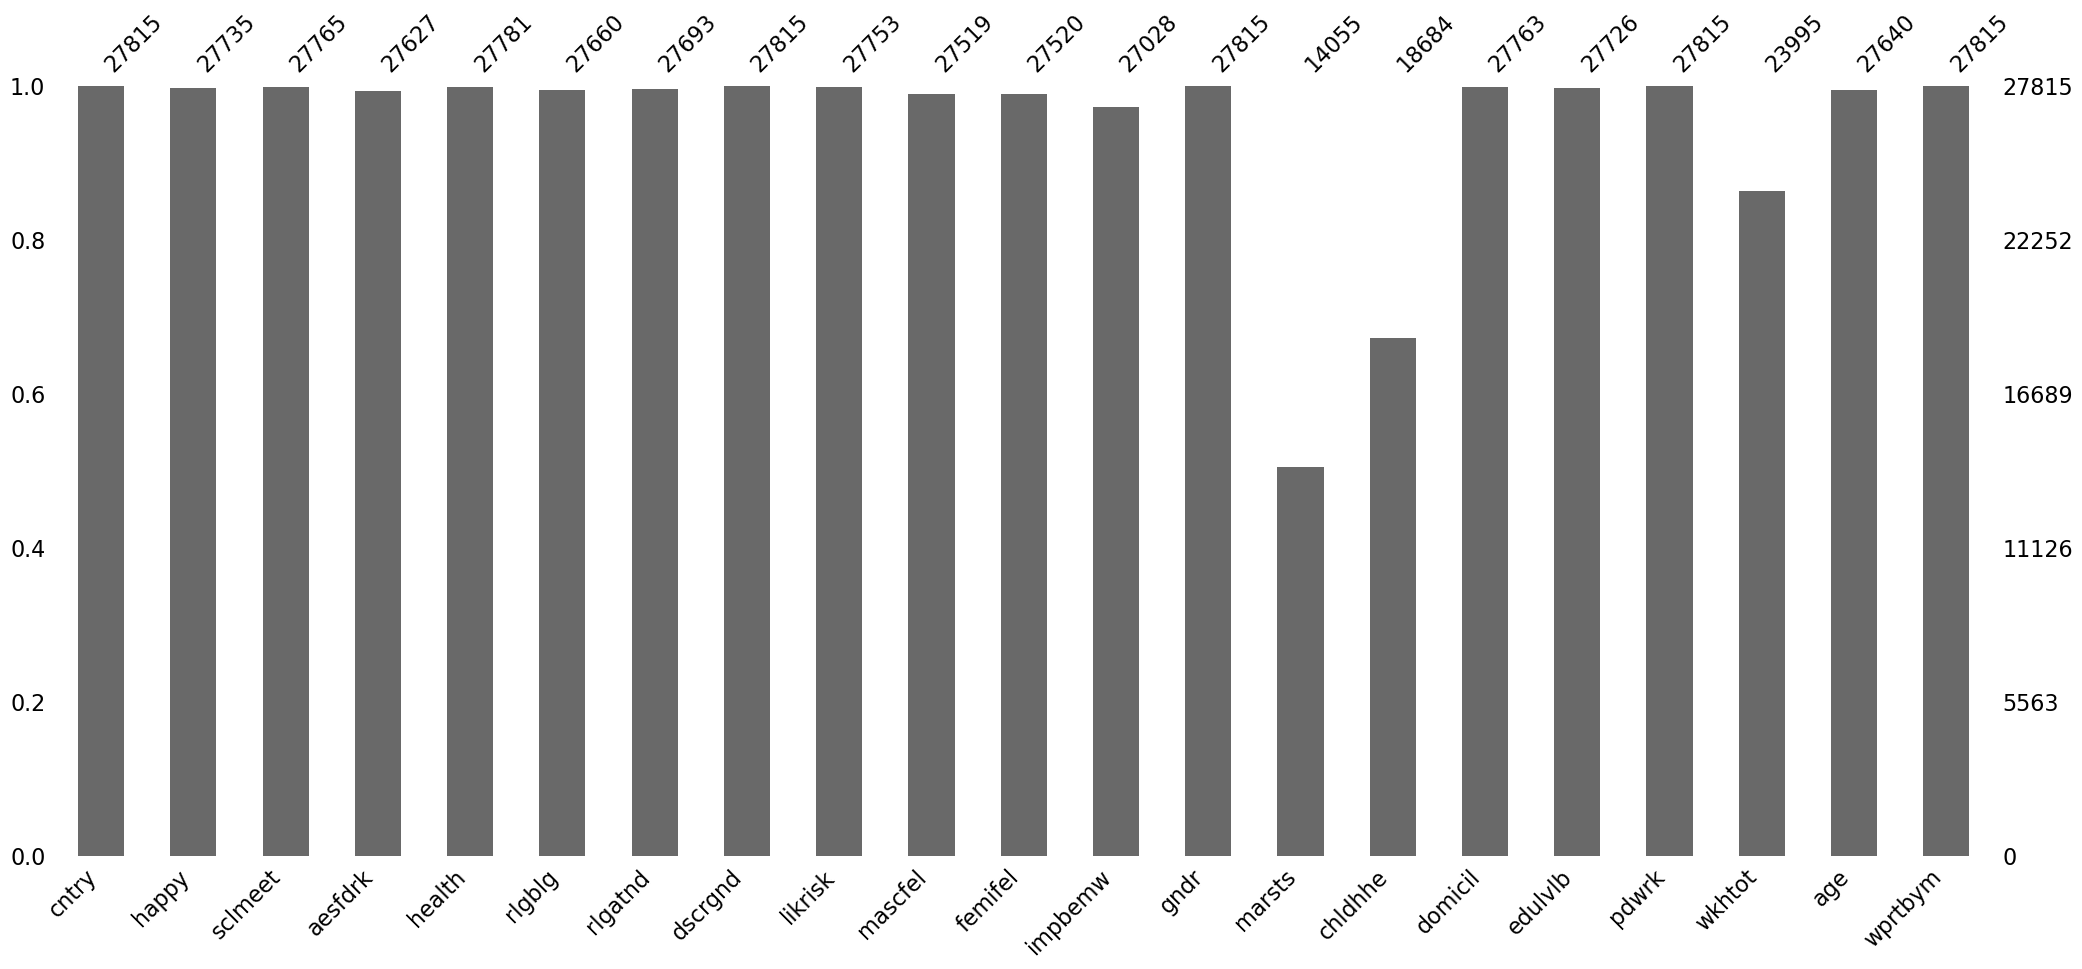

In [12]:
msno.bar(data_model)

We can see that the biggest number of missing values have columns 'marsts', 'chlghhe' and 'wkhtot'. Seems like responders didn't like to answer the question regarding marital status. Interesting observation. It's reasonable strategy to drop this column and don't use further in our models. Next, we can see that column for 'chlghhe' variable has more than 30% of missing values. One third of the participants doesn't want to provide answer for the question regarding children. Second interesting observation. It's also reasonable strategy to drop this column and don't use it further in our models. Regarding the 'wkhtot' variable, total hours normally worked per week in main job, it can be imputed, usign mode or KNN method. Other variables have a little percentage of missing values, so, they also can be imputed using different techniques [5,6]. 

<Axes: >

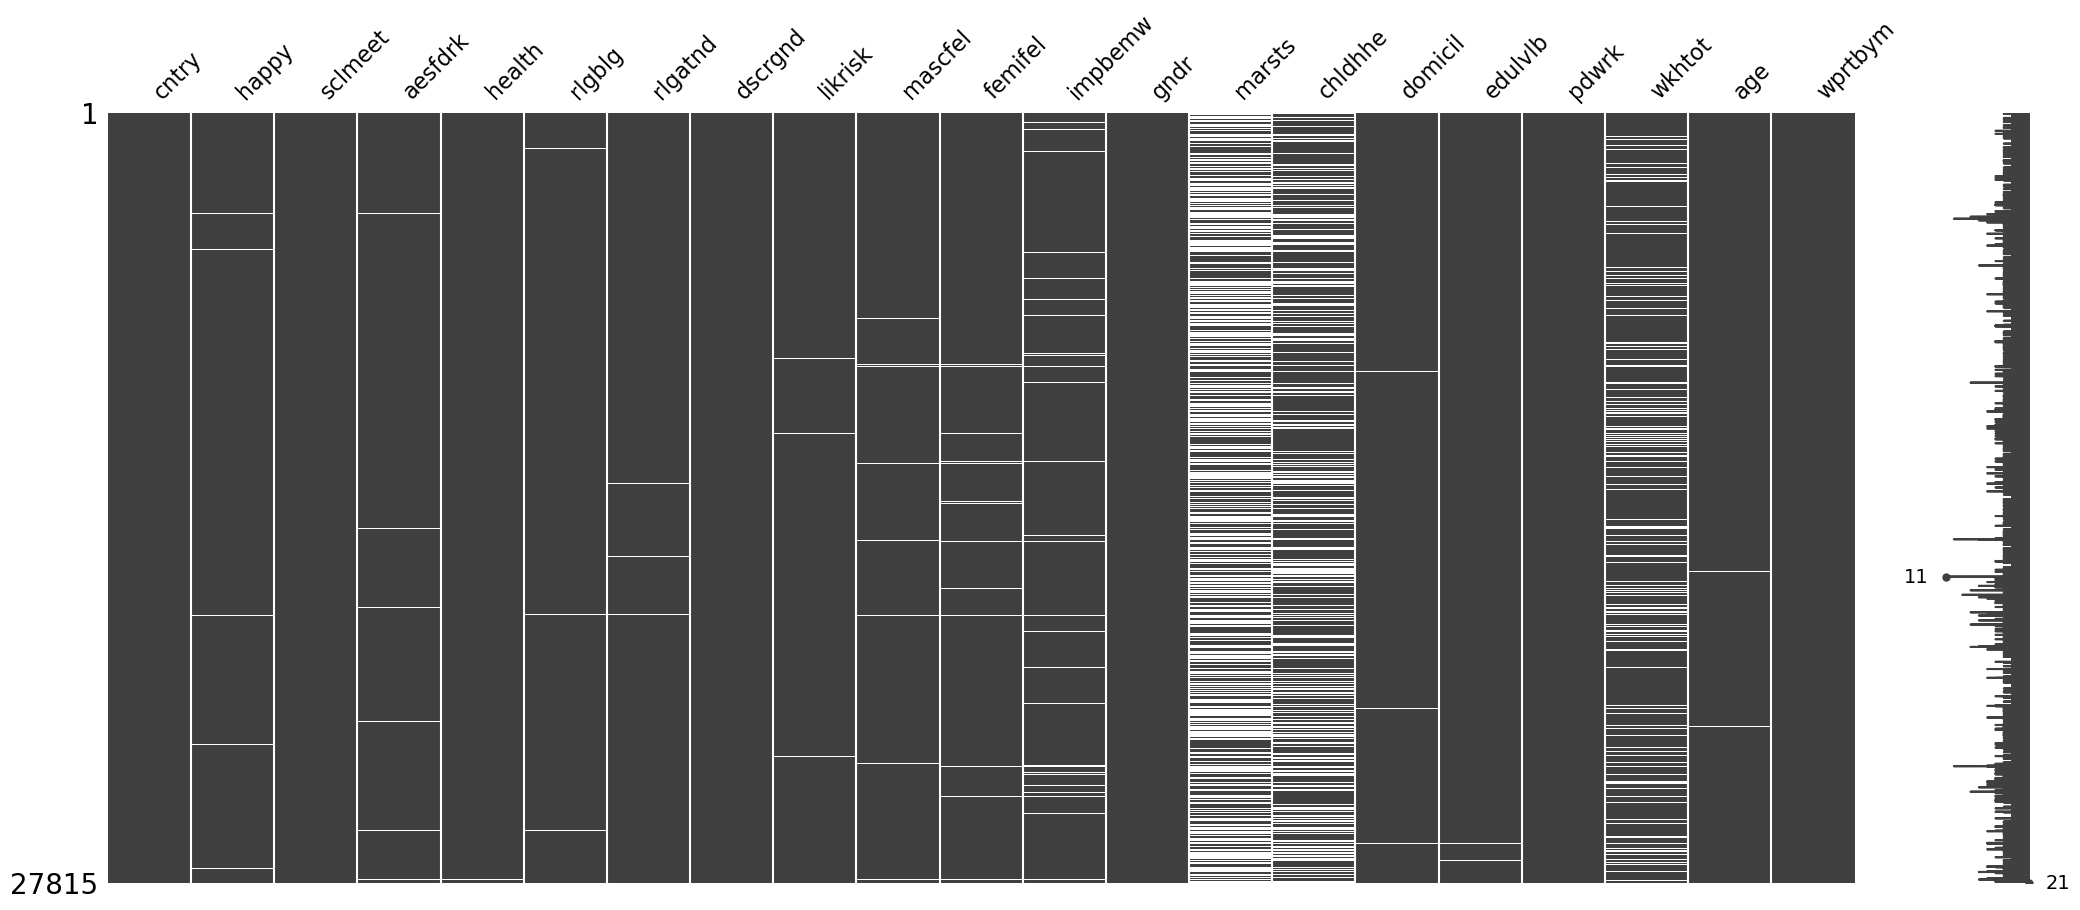

In [13]:
msno.matrix(data_model)

Variables like 'wkhtot', 'age', 'happy', 'sclmeet', and 'rlgatnd' have missing patterns that look more random across the rows, but they sometimes align with other missing variables (like 'wkhtot' aligning with some 'marsts' missingness). Variables 'impbemw', 'mascfel', and 'femifel' have small percentage of missing data, and their white blocks appear to be aligned vertically. This means that if a respondent is missing a value for 'impbemw', they are very likely also missing values for 'mascfel' and 'femifel'. This strongly suggests that the missingness mechanism is related to the specific topic of these questions (gender identity/importance). 

<Axes: >

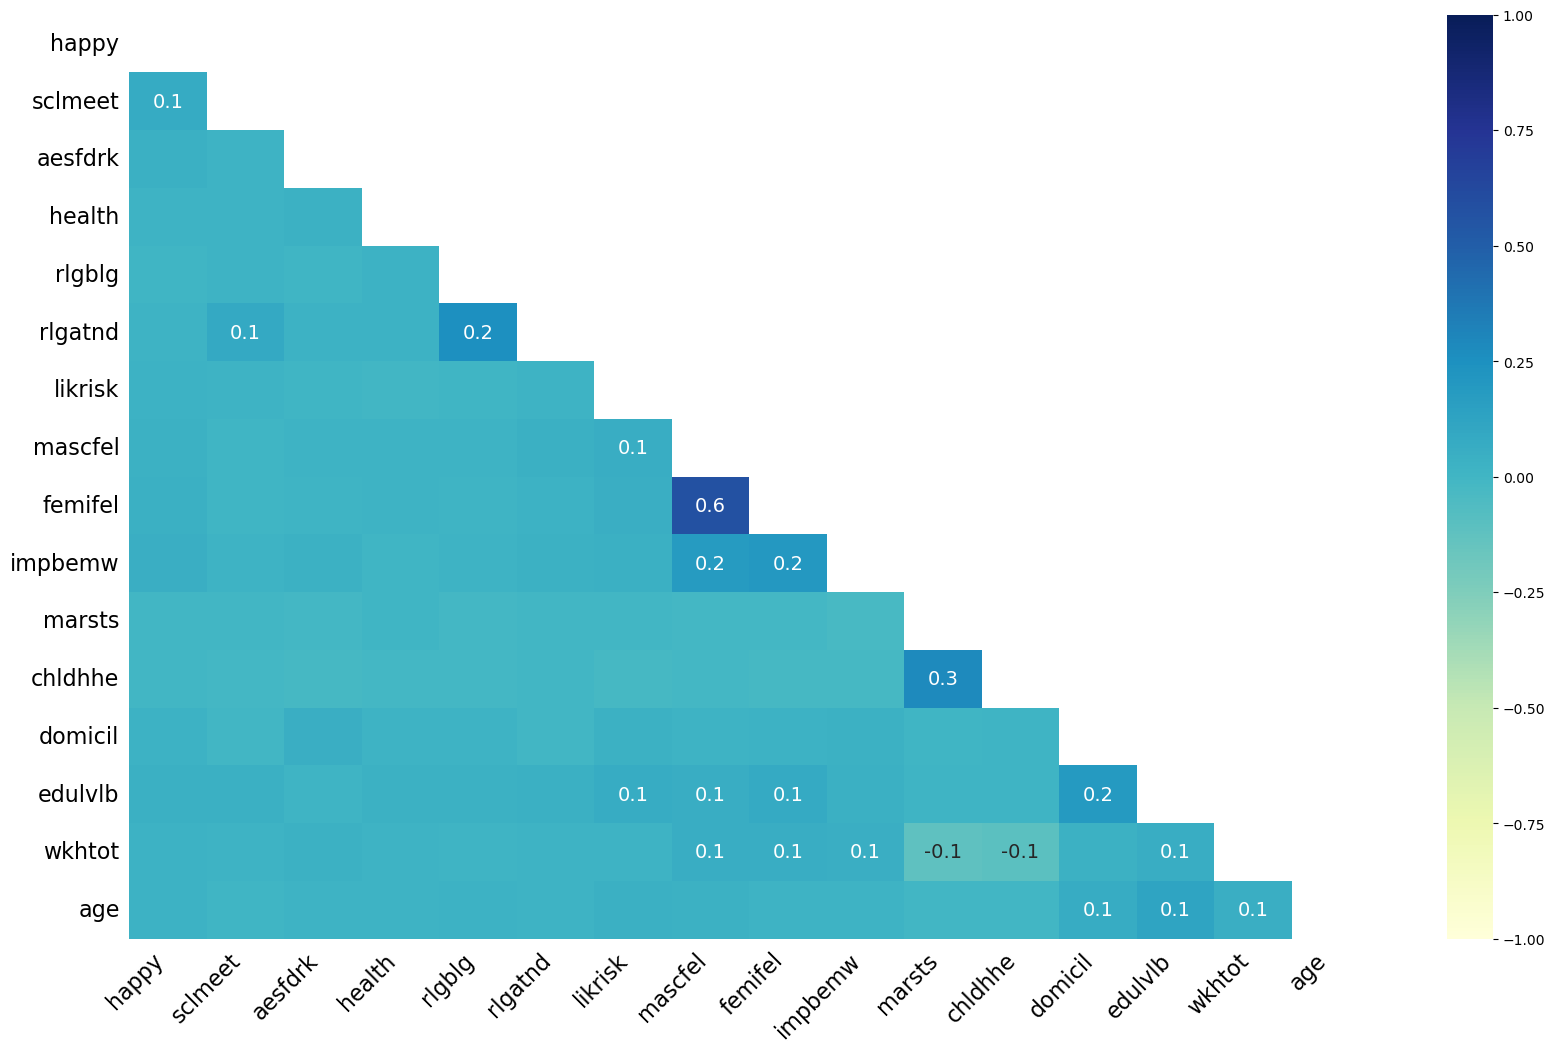

In [14]:
msno.heatmap(data_model, cmap="YlGnBu")

Missingness Correlation Heatmap, which measures how often the missingness of one variable co-occurs with the missingness of another. A score of (1.0) means they are always missing together. The variables 'mascfel' and 'femifel' are highly likely to be missing together  (0.6) sugessting a common underlying reason for non-response. <br> 
'impbemw' is correlated with both 'mascfel' and 'femifel' (0.2). While lower than 0.6, this confirms the cluster of missingness around the gender-related questions. <br> 
'rlgblg' and 'rlgatnd' (0.2) variables are moderately missing together, which makes sense as one is about belonging to a religion and the other is about attendance. If a respondent refuses one, they might refuse the other. <br>
There is a moderate positive correlation (0.3) between 'chldhhe' and 'marsts'. It means that records missing the 'chldhhe' value are moderately more likely to also be missing the 'marsts' value. So, it supports our previous findings. <br>
The correlation coefficients between 'mascfel', 'femifel', 'impbemw' (Gender Identity/Importance) vs. 'wkhtot' are weakly positive (apprx. 0.1) and suggest the missingness is mostly independent. The reasons for a non-response on highly sensitive gender identity questions are distinct from the reasons for a non-response on weekly work hours. This reinforces the finding that the gender identity variables ('mascfel' and 'femifel') form a strong, internal MNAR cluster (indicated by the strong correlation between them) and should be imputed primarily based on each other, rather than external factors like work hours. <br>
There is weak to moderate positive correlation (0.2) between 'edulvlb' (education level) and 'domicil'. Both variables have very low missingness. The slight correlation does not negate the use of the simple mode imputation for both, as the low volume of missing data means the bias introduced will be minimal, and the method is fast and preserves the discrete nature of the data. <br>
The correlation coefficients between 'marsts'/'chldhhe' and 'wkhtot' are slightly negative (apprx. -0.1). A correlation close to zero indicates largely independent missingness patterns. The factors causing non-response for personal status ('marsts', 'chldhhe') are mostly different from the factors causing non-response for work status ('wkhtot'). This supports treating 'wkhtot' separately for the further imputation strategy. <br>
To sum up, we can impute the highly/moderately correlated clusters using KNN, focusing on 'mascfel', 'femifel', 'impbemw' and 'wkhtot' as they are strongly predictive of each other missingness. Use Mode/Median for all other low-missingness variables.

In [15]:
data_model = data_model.drop(['marsts','chldhhe'], axis = 1)

# Check variables statistics
data_model.describe(include=[np.number], percentiles=[.5]) \
    .transpose().drop("count", axis=1)

,mean,std,min,50%,max
happy,7.499081,1.812472,0.0,8.0,10.0
sclmeet,4.784621,1.587595,1.0,5.0,7.0
aesfdrk,1.880081,0.77057,1.0,2.0,4.0
health,2.164141,0.917581,1.0,2.0,5.0
rlgblg,1.343637,0.47493,1.0,1.0,2.0
rlgatnd,5.346152,1.531552,1.0,6.0,7.0
dscrgnd,0.01474,0.120513,0.0,0.0,1.0
likrisk,2.625518,1.852314,0.0,3.0,6.0
mascfel,2.931502,2.559985,0.0,3.0,6.0
femifel,2.939753,2.57356,0.0,3.0,6.0


#### 1.3. Data imputation on the train dataset 

In [16]:
# Split the dataset for train and test 

# Target: 0/1  disagree vs agree 
y = data_model['wprtbym']   
# Features: 
X = data_model.drop(columns=['wprtbym'])

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,        
    random_state=42,      
    stratify=y            
)

In [17]:
# Impute with median continuous/ordinal variables
age_median = X_train['age'].median()
happy_median = X_train['happy'].median()
likrisk_median = X_train['likrisk'].median()

# Impute with mode categorical/low-missingness ordinal variables
health_mode = X_train['health'].mode()[0]
domicil_mode = X_train['domicil'].mode()[0]
sclmeet_mode = X_train['sclmeet'].mode()[0]
aesfdrk_mode = X_train['aesfdrk'].mode()[0]
rlgblg_mode = X_train['rlgblg'].mode()[0]
rlgatnd_mode = X_train['rlgatnd'].mode()[0]
edulvlb_mode = X_train['edulvlb'].mode()[0]

def imputing_na(df):
    imputation_map = {
        'age': age_median,
        'happy': happy_median,
        'likrisk': likrisk_median,
        'health': health_mode,
        'domicil': domicil_mode,
        'sclmeet': sclmeet_mode,
        'aesfdrk': aesfdrk_mode,
        'rlgblg': rlgblg_mode,
        'rlgatnd': rlgatnd_mode,
        'edulvlb': edulvlb_mode
    }

    df.fillna(imputation_map, inplace=True) 

    print(df.isna().sum())
    return df

In [18]:
imputing_na(X_train)

cntry         0
happy         0
sclmeet       0
aesfdrk       0
health        0
rlgblg        0
rlgatnd       0
dscrgnd       0
likrisk       0
mascfel     231
femifel     232
impbemw     634
gndr          0
domicil       0
edulvlb       0
pdwrk         0
wkhtot     3065
age           0
dtype: int64


,cntry,happy,sclmeet,aesfdrk,health,rlgblg,rlgatnd,dscrgnd,likrisk,mascfel,femifel,impbemw,gndr,domicil,edulvlb,pdwrk,wkhtot,age
546,AT,9.0,4.0,1.0,2.0,1,5.0,0,0.0,5.0,0.0,4.0,1,5.0,322.0,0,40.0,76.0
6296,DE,8.0,5.0,2.0,2.0,1,6.0,0,6.0,6.0,0.0,5.0,1,1.0,322.0,1,40.0,60.0
32083,PL,6.0,4.0,2.0,2.0,2,6.0,0,3.0,0.0,6.0,3.0,2,3.0,313.0,0,NaN,25.0
21822,IE,9.0,6.0,1.0,2.0,2,7.0,0,3.0,6.0,0.0,3.0,1,3.0,620.0,0,22.0,53.0
24143,IS,9.0,7.0,3.0,2.0,1,6.0,0,2.0,0.0,6.0,NaN,2,2.0,720.0,1,36.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11028,FI,8.0,6.0,1.0,3.0,2,7.0,0,5.0,4.0,2.0,3.0,1,2.0,710.0,1,15.0,78.0
23390,IE,8.0,3.0,2.0,1.0,1,7.0,0,3.0,0.0,5.0,6.0,2,2.0,720.0,1,0.0,54.0
27336,IT,7.0,5.0,2.0,2.0,1,4.0,0,3.0,6.0,0.0,6.0,1,4.0,113.0,1,10.0,38.0
5515,CY,7.0,4.0,2.0,1.0,1,3.0,0,4.0,6.0,0.0,6.0,1,2.0,313.0,1,48.0,42.0


In [ ]:
knn_cols = ['wkhtot', 'impbemw', 'mascfel', 'femifel']
var_ranges = {
    'mascfel': (0, 6),
    'femifel': (0, 6),
    'impbemw': (0, 6),
    'wkhtot': (0, 168),   # hours per week
}

def fit_knn_imputer(df, knn_cols):
    feats = df.select_dtypes(include=np.number).columns.tolist()
    scaler = StandardScaler()
    imputer = KNNImputer(n_neighbors=5)

    df_scaled = scaler.fit_transform(df[feats])
    df_imp_scaled = imputer.fit_transform(df_scaled)
    df_imp = scaler.inverse_transform(df_imp_scaled)
    df_imp = pd.DataFrame(df_imp, columns=feats, index=df.index)

    for col, (low, high) in var_ranges.items():
        df_imp[col] = df_imp[col].clip(lower=low, upper=high)
        if col in knn_cols:
            df_imp[col] = df_imp[col].round()

    for col in knn_cols:
        df[col] = df_imp[col]

    return df, scaler, imputer, feats

def apply_knn_imputer(df, knn_cols, scaler, imputer, feats):
    df_scaled = scaler.transform(df[feats])
    df_imp_scaled = imputer.transform(df_scaled)
    df_imp = scaler.inverse_transform(df_imp_scaled)
    df_imp = pd.DataFrame(df_imp, columns=feats, index=df.index)

    for col, (low, high) in var_ranges.items():
        df_imp[col] = df_imp[col].clip(lower=low, upper=high)

        if col in knn_cols:
            df_imp[col] = df_imp[col].round()

    for col in knn_cols:
        df[col] = df_imp[col]        

    return df


In [20]:
X_train, scaler, imputer, feats = fit_knn_imputer(X_train, knn_cols)
imputing_na(X_train)
X_train.describe(include=[np.number], percentiles=[.5]) \
    .transpose().drop("count", axis=1)

cntry      0
happy      0
sclmeet    0
aesfdrk    0
health     0
rlgblg     0
rlgatnd    0
dscrgnd    0
likrisk    0
mascfel    0
femifel    0
impbemw    0
gndr       0
domicil    0
edulvlb    0
pdwrk      0
wkhtot     0
age        0
dtype: int64


,mean,std,min,50%,max
happy,7.498966,1.8069,0.0,8.0,10.0
sclmeet,4.789143,1.584988,1.0,5.0,7.0
aesfdrk,1.88046,0.767,1.0,2.0,4.0
health,2.168794,0.916887,1.0,2.0,5.0
rlgblg,1.340733,0.473967,1.0,1.0,2.0
rlgatnd,5.351834,1.531015,1.0,6.0,7.0
dscrgnd,0.01456,0.119788,0.0,0.0,1.0
likrisk,2.63064,1.848751,0.0,3.0,6.0
mascfel,2.925535,2.555849,0.0,3.0,6.0
femifel,2.936186,2.567759,0.0,3.0,6.0


In [ ]:
# Impute missing values in the test set 
X_test = apply_knn_imputer(X_test, knn_cols, scaler, imputer, feats)
imputing_na(X_test)
X_test.describe(include=[np.number], percentiles=[.5]) \
    .transpose().drop("count", axis=1)

cntry      0
happy      0
sclmeet    0
aesfdrk    0
health     0
rlgblg     0
rlgatnd    0
dscrgnd    0
likrisk    0
mascfel    0
femifel    0
impbemw    0
gndr       0
domicil    0
edulvlb    0
pdwrk      0
wkhtot     0
age        0
dtype: int64


,mean,std,min,50%,max
happy,7.506741,1.82281,0.0,8.0,10.0
sclmeet,4.777458,1.595148,1.0,5.0,7.0
aesfdrk,1.882617,0.772173,1.0,2.0,4.0
health,2.144526,0.917468,1.0,2.0,5.0
rlgblg,1.345677,0.475631,1.0,1.0,2.0
rlgatnd,5.359698,1.536517,1.0,6.0,7.0
dscrgnd,0.015459,0.123382,0.0,0.0,1.0
likrisk,2.609204,1.856716,0.0,3.0,6.0
mascfel,2.923962,2.566863,0.0,3.0,6.0
femifel,2.937983,2.587192,0.0,3.0,6.0


### 2. EDA

#### 2.1. Target variable

In [22]:
y_train.value_counts(normalize=True)

wprtbym
1.0    0.744832
0.0    0.255168
Name: proportion, dtype: float64

(array([ 5678.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 16574.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

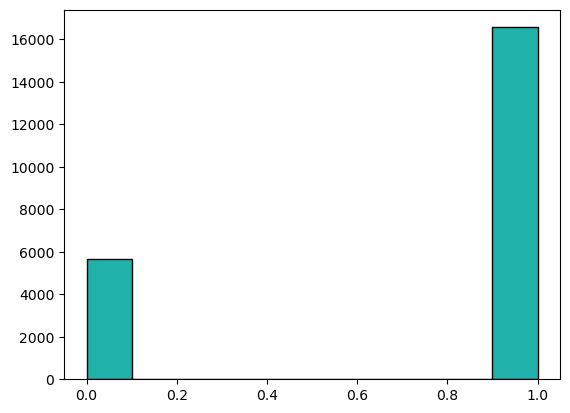

In [ ]:
plt.hist(y_train, color='lightseagreen', edgecolor='black')

The plot illustrates that larger share of respondents agree with the statement “women should be protected by men” (coded 1) than disagree (coded 0). The target variable is skewed towards agreement, implying that metrics like accuracy alone may be misleading and that we need also consider precision, recall, and F1 for the minority (disagree) class when evaluating models.

#### 2.2. Correlation matrix

<Axes: >

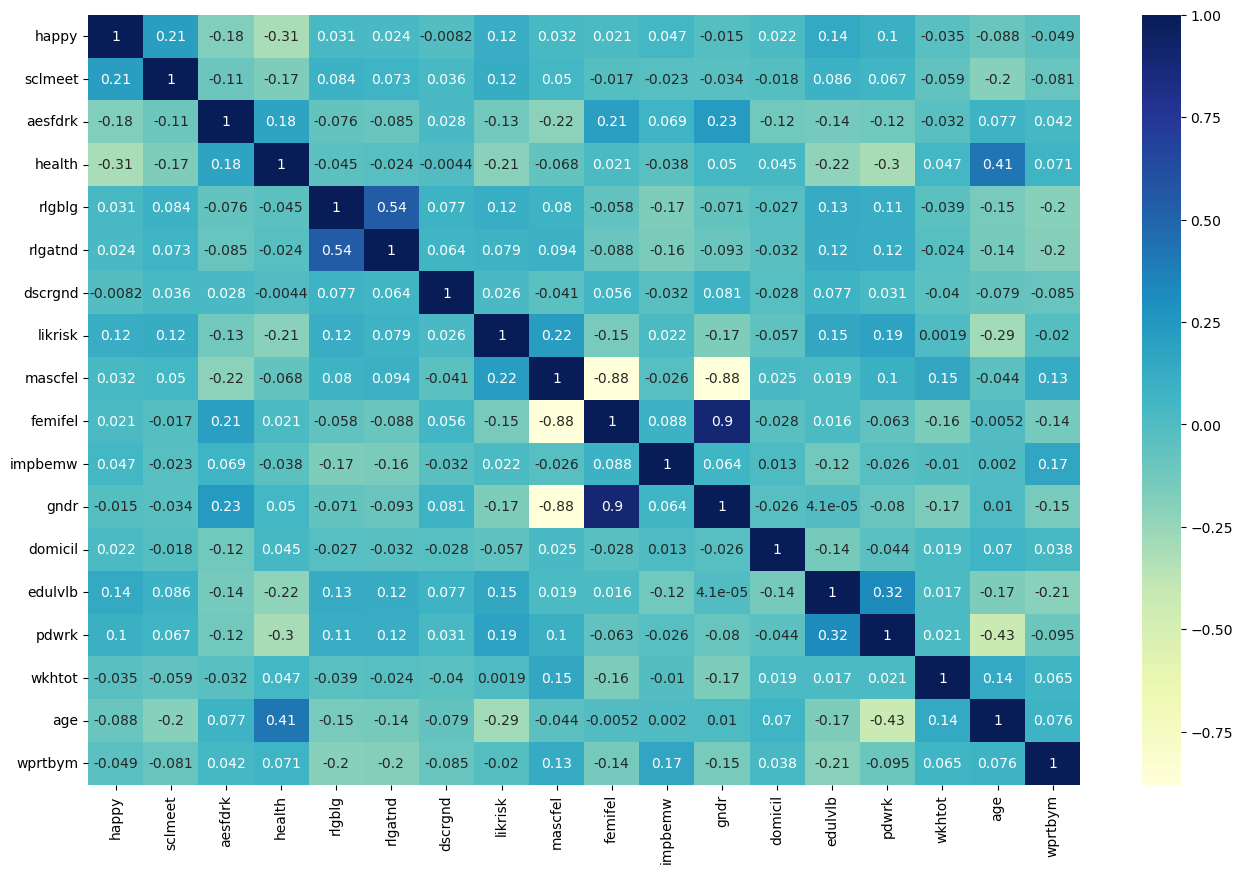

In [ ]:
train = X_train.join(y_train)
plt.figure(figsize=(16,10))
sns.heatmap(train.corr(numeric_only = True), cmap='YlGnBu', annot=True)

The correlation matrix shows that 'wprtbym' (agreement that “women should be protected by men”) has only weak linear correlations with individual predictors, but the signs and relative magnitudes are substantively interpretable and still could be useful for modeling. The largest positive correlations are with: 'impbemw' (importance of being a man/woman,  0.17), 'age' (0.08), 'happy' and 'wkhtot' (0.07). The largest negative correlations are with: 'likrisk' (liking risk, −0.13),
'pdwrk' (working last 7 days, −0.095), 'aesfdrk' (safety after dark, −0.08). <br>
This indicates that respondents who see gender as more central to their identity, are older, and perhaps somewhat more satisfied or working fewer hours, tend to agree slightly more with the protection statement, while those with higher risk tolerance or currently working tend to agree slightly less. The effect sizes, however, is small. This framing both acknowledges the small correlations and justifies continuing with 'wprtbym' as a meaningful but challenging classification target.

#### 2.3. High positive correlation

Firstly, we want to visualize the distribution of the variables that are highly and positively correlated between each other, according to what we saw in the heatmap. Namely, these variables are: 'age' vs. 'health' (0.41),'gndr' vs. 'femilfel' (0.9), and 'rlgatnd' vs. 'rlgblg' (0.54). Let's start with distribution of the variables. 

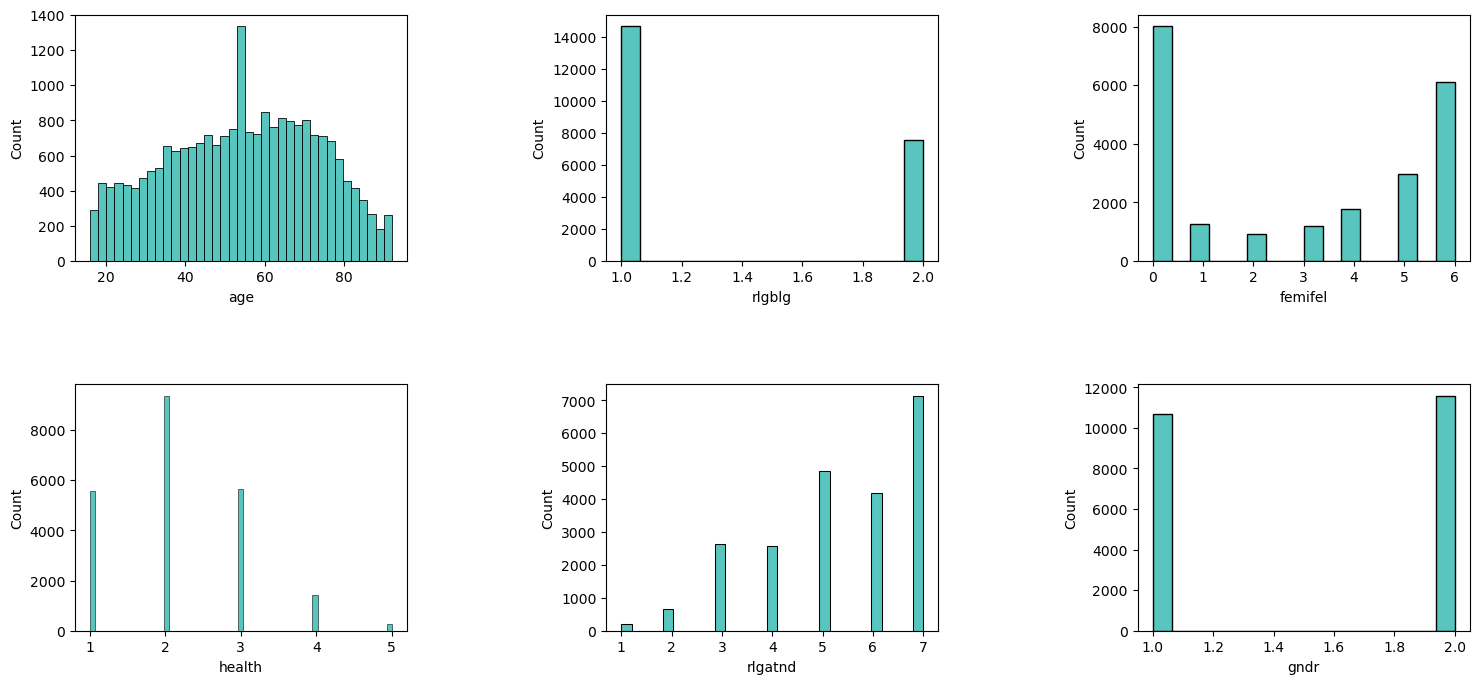

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(18,8))
fig.subplots_adjust(hspace=0.5, wspace=0.6)
for ax, v in zip(axes.flat, ['age', 'rlgblg','femifel',
                             'health', 'rlgatnd','gndr']):
    sns.histplot(train[v], kde=False, color='lightseagreen',
                 ax=ax)
    ax.set(ylabel="Count");

The first distribution pair set, 'age' and 'health' variables, illustrates that the age histogram is roughly bell‑shaped with most respondents between about 30 and 80, peaking around the mid‑50s. The health histogram is strongly skewed to “good” values: most people report 2 (“good”) or 3 (“fair”), with fewer at 1 (“very good”) and very few at 4–5 (“bad/very bad”). Given these shapes, a positive correlation around 0.4 means that as age increases, the distribution shifts gradually toward worse self‑reported health: older respondents are more likely to choose 3–5 instead of 1–2, even though good health is still common at many ages. <br>

The second distribution pair set, 'rlgblg' vs. 'rlgatnd' variables, shows that 'rlgblg' almost binary in practice: a large bar at 1 (“belongs to a religion”) and a sizeable but smaller bar at 2 (“does not belong”). 'rlgatnd' spans 1–7, but the distribution is concentrated at higher numeric codes (infrequent attendance / never), with fewer people at 1–3 (frequent attendance). The moderate positive correlation arises because belonging and attendance co‑move: those who say they belong to a religion are more likely to choose lower 'rlgatnd' values (more frequent attendance), while non‑belongers cluster at high 'rlgatnd' values (rarely or never attend), but there is still overlap (some belongers attend rarely, some non‑belongers attend occasionally). <br>

The third distribution pair set, 'femifel' and 'gndr', shows that 'gndr' has two clear spikes at 1 and 2 (male/female). We can see that most of the respondents are women, but the number is little slightly bigger, than number of men participated. 'femifel' is bimodal: a large mass at 0 (“not at all feminine”) and another large mass at 6 (“very feminine”), with smaller counts in between. A correlation of ~0.9 is expected here: males (1) mostly cluster at low femifel values, and females (2) mostly cluster at high femifel values. The distributions are essentially separating by sex, so “feeling feminine” is almost a proxy for gender in this sample.<br>

#### 2.4. Moderate positive correlation <br>
Secondly, we want to visualize the distribution of the variables that are moderately and positively correlated  between each other, according to what we saw in the heatmap. 

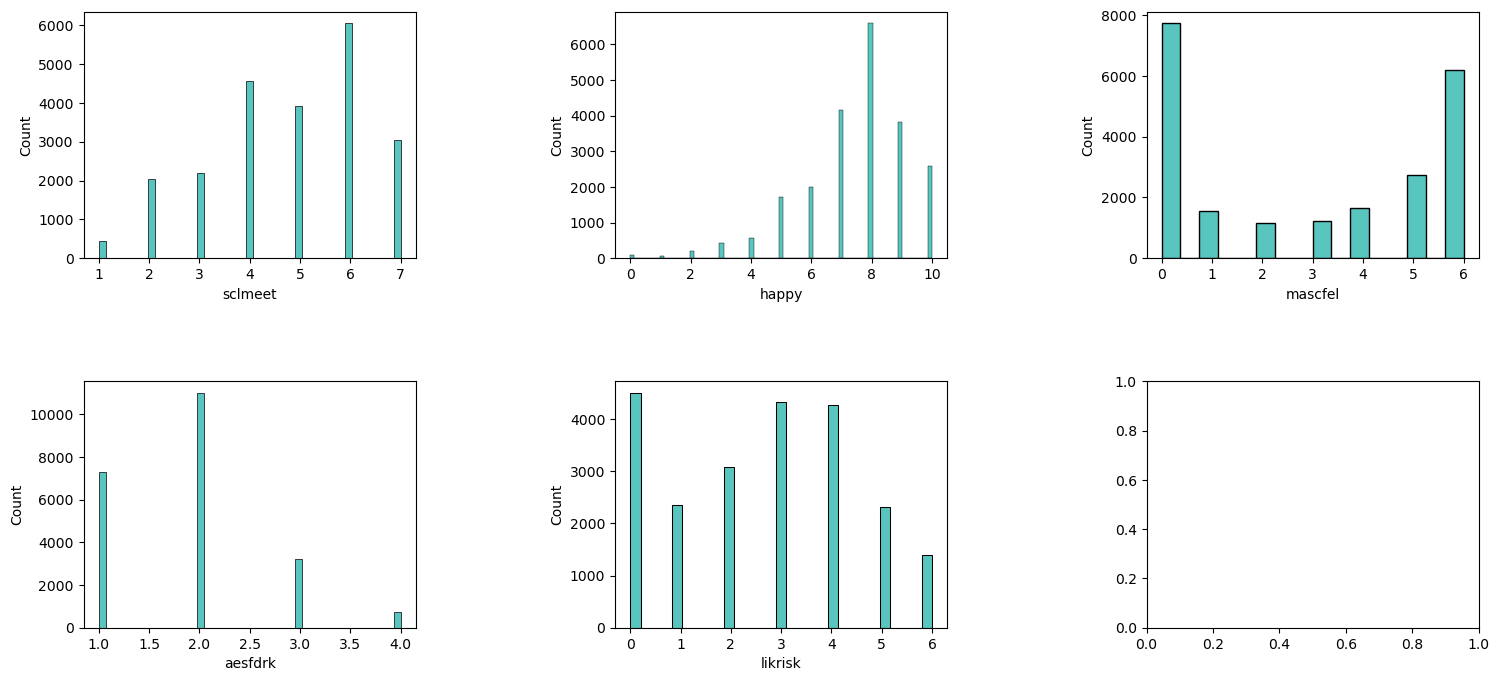

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(18,8))
fig.subplots_adjust(hspace=0.5, wspace=0.6)
for ax, v in zip(axes.flat, ['sclmeet', 'happy', 'mascfel',
                              'aesfdrk', 'likrisk']):
    sns.histplot(train[v], kde=False, color='lightseagreen',
                 ax=ax)
    ax.set(ylabel="Count");

The histograms and the correlation matrix together tell a consistent story about how these variables relate to each other. 'sclmeet' (social meetings) is right‑skewed toward higher values: many respondents meet friends “several times a month” to “several times a week”, fewer report very low contact. 'happy' is also skewed toward high values, with most answers between 6 and 9 on the 0–10 scale; very low happiness is rare. 'mascfel' is U‑shaped: a big group at 0 (“not at all masculine”) and another big group at 6 (“very masculine”), with fewer in the middle. Pretty the same pattern for the 'femifel' variable. 'aesfdrk' (safety after dark) is concentrated on 1–3, mostly at 1–2 (“very safe/safe”), with relatively few at 4 (“very unsafe”). 'likrisk' is more spread: there is mass at both low risk‑taking (0–1) and moderate risk‑taking (3–4), with fewer at the extreme of high risk-taking. These shapes already suggest that many respondents report positive social, emotional, and safety conditions, while gender‑identity items are more polarized. <br>
From the matrix correlations for the following pairs are moderate (roughly 0.2–0.3): 'sclmeet' vs. 'happy' (0.21). This correlation reflects a general tendency, where more frequent social contact is associated with greater self‑reported happiness, though the effect is far from deterministic. 'gndr' vs. 'aesfdrk', gender and perceived safety after dark are linked: one gender group reports feeling unsafe somewhat more often. Because 'aesfdrk' is skewed toward “safe” overall, the correlation indicates that the minority feeling unsafe is disproportionately concentrated in one gender category, generating this modest positive association. 'femifel' vs. 'aesfdrk' (0.21), those scoring higher on “feeling feminine” are more likely to report feeling unsafe, while those scoring low on feminity concentrate more on “very safe / safe”; the bimodal distribution of 'femifel' and the skew of 'aesfdrk' together produce this moderate positive correlation. 'health' vs. 'aesfdrk' (0.18), this suggests that respondents in poor health are somewhat more likely to choose higher (more unsafe) categories, but many healthy people also report feeling safe. 'mascfel' vs. 'likrisk' (0.22), respondents who feel more masculine tend to score higher on risk‑taking. 
Overall,  these pairs show meaningful but moderate associations. None of these relationships is strong enough to cause multicollinearity problems, but they fit well with substantive expectations from social behavior.

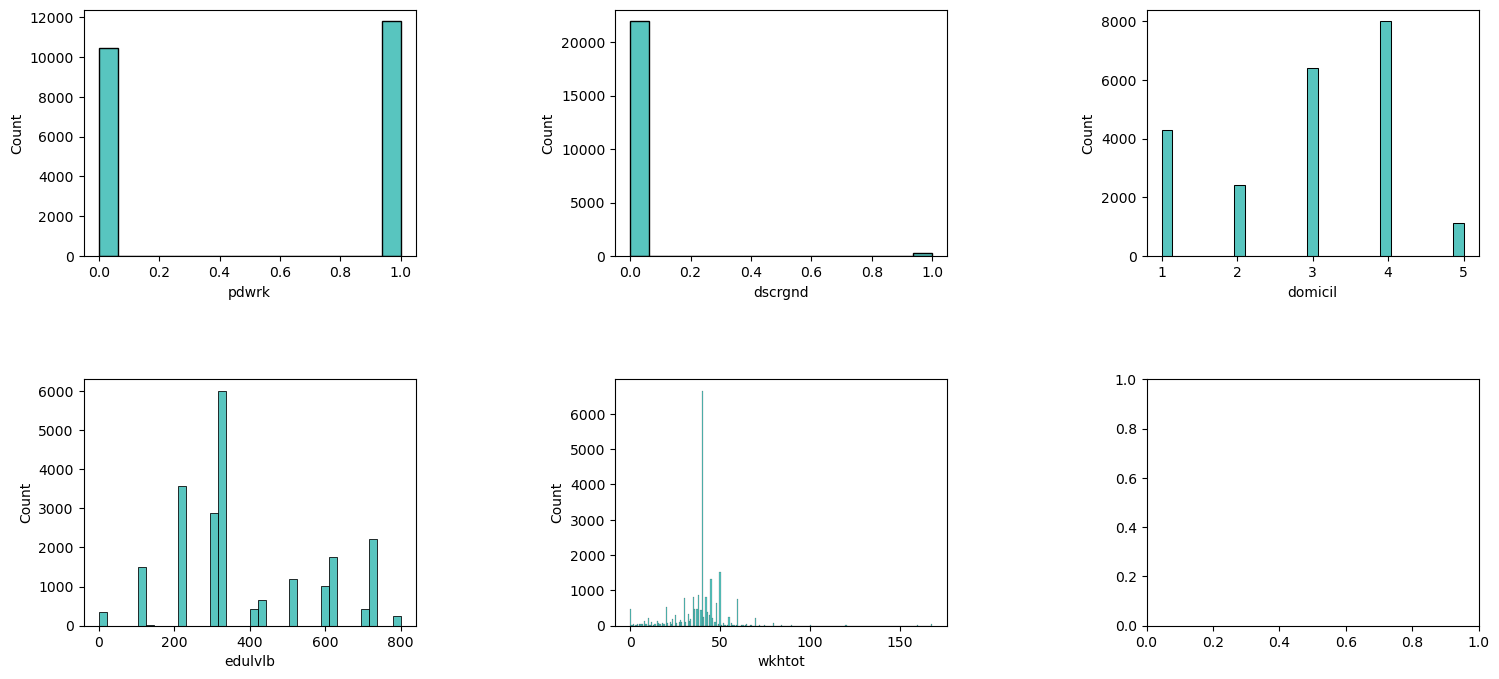

In [27]:
# Plot all other variables distribution 
fig, axes = plt.subplots(2, 3, figsize=(18,8))
fig.subplots_adjust(hspace=0.5, wspace=0.6)
for ax, v in zip(axes.flat, ['pdwrk','dscrgnd','domicil',
                             'edulvlb', 'wkhtot']):
    sns.histplot(train[v], kde=False, color='lightseagreen',
                 ax=ax)
    ax.set(ylabel="Count");

From the last grid of histograms, the remaining variables have the following main patterns: <br>
'pdwrk' (paid work last 7 days) is almost balanced. This means a substantial share of respondents are in paid work and a substantial share are not, which will help the model learn differences by labour‑market status. 'dscrgnd' (experienced gender discrimination) is extremely skewed: the bar at 0 dominates, with only a small bar at 1. Very few respondents report discrimination. This variable is highly imbalanced and will contribute limited variation, but it may still capture a specific subgroup signal. 'domicil' (place of residence) shows all 5 categories used, with the highest counts in codes 3–4 (town/small city, country village) and fewer in big city (1) and countryside farm (5). Urban and semi‑urban residences dominate. 'edulvlb' (education code) is multi‑modal with several spikes at specific codes (e.g. 322, 423, 620, 710, 720, 1), corresponding to common educational qualifications. Lower codes around 200–400 are most frequent, while very high codes like 1 are rare. 'wkhtot' (weekly working hours) is right‑skewed with a strong peak around 40 hours and a long tail toward high hours (up to ~160). Many workers cluster at standard full‑time hours, with smaller groups at part‑time and some at very long hours. Zero or very low hours appear for some people despite being marked as in paid work, likely reflecting marginal or irregular work time. <br>
Overall, these distributions show that most remaining predictors are either clearly binary, multi‑category nominal, or skewed continuous quantities, which could justify the further preprocessing strategy.

#### 2.5. High negative correlation <br>
Next, we want to visualize the distribution of the variables that are highly and negatively correlated  between each other, according to what we saw in the heatmap. <br>
'femifel' vs. 'mascfel' (−0.88), because both scales run from 0 to 6 and many people sit at extremes (very masculine vs very feminine). Those who rate themselves high on femininity tend to rate low on masculinity, and vice versa.​ The U‑shaped distributions that are mirror images explain the very strong negative correlation: as one scale increases, the other decreases almost linearly at the aggregate level. 'mascfel' vs. 'gndr' (−0.88) males cluster at high masculinity values, females at low values.​ This produces a strong negative correlation: moving from gender code 1 to 2 is associated with a large drop in 'mascfel'. 'age' vs. 'pdwrk' (−0.43), older respondents are much more likely to be out of paid work (retired), whereas prime‑age respondents more often have: 'pdwrk' = 1.​​ Since age has a wide spread and 'pdwrk' is binary, the negative correlation reflects that the probability of being in paid work declines with age; younger people cluster at 'pdwrk' = 1, older at 'pdwrk' = 0. age vs. 'likrisk' (−0.29) younger respondents tend to report higher willingness to take risks, while risk appetite gradually declines with age.​<br>
To sum up, these strong negative correlations capture expected social patterns. Despite the high correlations, they mainly pose interpretation issues for linear models; tree‑based models can handle them without serious numerical problems.

#### 2.6. Moderately negative correlation <br>
Next, we want to visualize the distribution of the variables that are moderately and negatively correlated  between each other, according to what we saw in the heatmap. The moderate negative correlations we highlighted are all consistent with the shapes of the distributions and with plausible social patterns.<br>
'health' vs. 'happy' (−0.30), where health is coded so that higher values mean worse health (1 = very good, 5 = very bad), while happy is coded so that higher values mean more happiness. Both distributions are skewed toward “good” outcomes (most people report good health and high happiness), but there is variation.​The negative correlation means that as self‑reported health gets worse (health = 4–5), average happiness decreases; individuals with very bad health are more likely to give lower happiness scores. This is a moderate but not extreme pattern: many people in fair or even poor health still report high happiness. 'health' vs. 'likrisk' (−0.29), where 'likrisk' measures willingness to take risks and is spread across the 0–6 scale, with mass at both low and moderate risk.​ The negative correlation indicates that respondents in worse health tend to report somewhat lower risk‑taking. People with very good health can be found at all risk levels, but as health declines, the distribution shifts toward the low‑risk end, lowering the overall mean. 'mascfel' vs. 'aesfdrk' (−0.22), the negative correlation (given that higher 'aesfdrk' means feeling more unsafe) suggests that those who feel more masculine tend, on average, to report greater safety after dark, while those scoring low on masculinity report slightly more insecurity. The effect is moderate: many high‑masculinity respondents still feel unsafe, and many low‑masculinity respondents feel safe. 'age' vs. 'sclmeet' (−0.20),the negative correlation reflects that older respondents meet friends less often: as age increases, the distribution of 'sclmeet' shifts from “several times a week/every day” toward “once a week/less often”. Younger adults cluster more at high contact frequencies, pulling the correlation negative.<br>
None of these correlations is strong enough to cause modeling problems, but they provide useful substantive context for interpreting later model results.

#### 2.7. Common trends

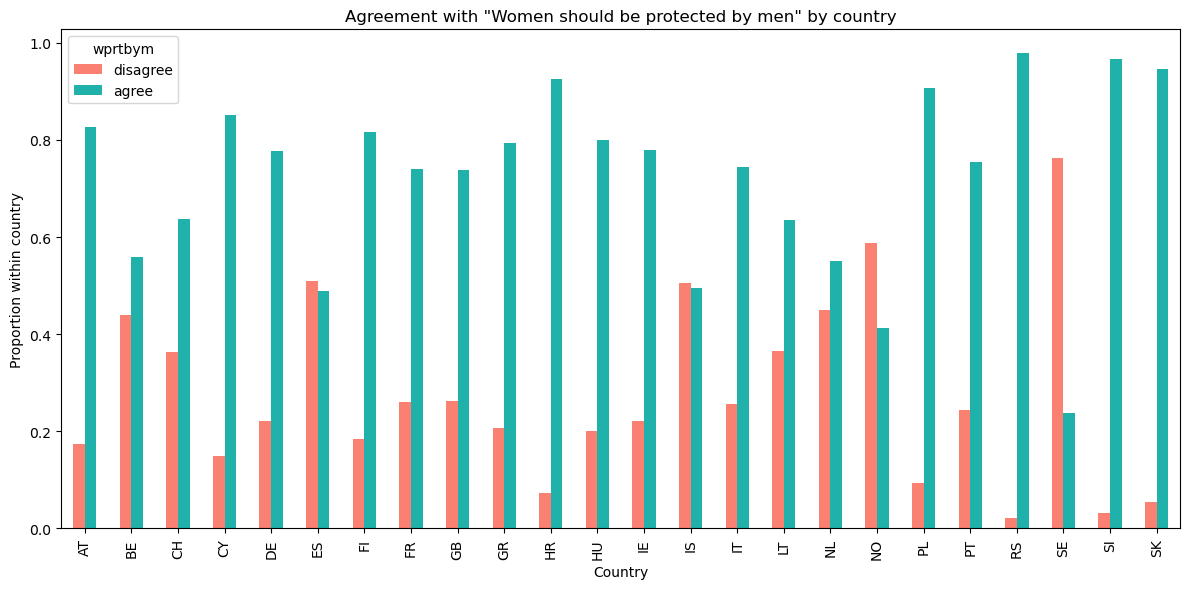

In [28]:
cntry_ct = pd.crosstab(X_train['cntry'], y_train, normalize='index')

cntry_ct.columns = ['disagree', 'agree']

ax = cntry_ct.plot(kind='bar', figsize=(12, 6), color=['salmon', 'lightseagreen'])
ax.set_xlabel('Country')
ax.set_ylabel('Proportion within country')
ax.set_title('Agreement with "Women should be protected by men" by country')
plt.legend(title='wprtbym')
plt.tight_layout()
plt.show()

The plot shows within‑country proportions of disagreement and agreement with “Women should be protected by men”, so each pair of bars sums to 1 for a given country.  From this plot we could find quite curious patterns. In most countries the lightseagreen bar (agree) is clearly higher than the salmon bar (disagree), confirming the overall skew of the target variable toward agreement. Countries such as HR, HU, PL, PT, SE, SI, and SK show very high agreement shares (around 90–100%), meaning that disagreement is rare there. A few countries have more balanced attitudes, where disagreement approaches or slightly exceeds 40–50%: examples include IS, NL, LT, and ES. In these contexts, the norm that “women should be protected by men” is more contested. Some countries stand out with relatively high disagreement (short agree bar, tall disagree bar) compared to the rest, suggesting cross‑national variation in gender‑norm attitudes that the future models may exploit via the 'cntry' feature. Thus, the country context is likely an important predictor. 

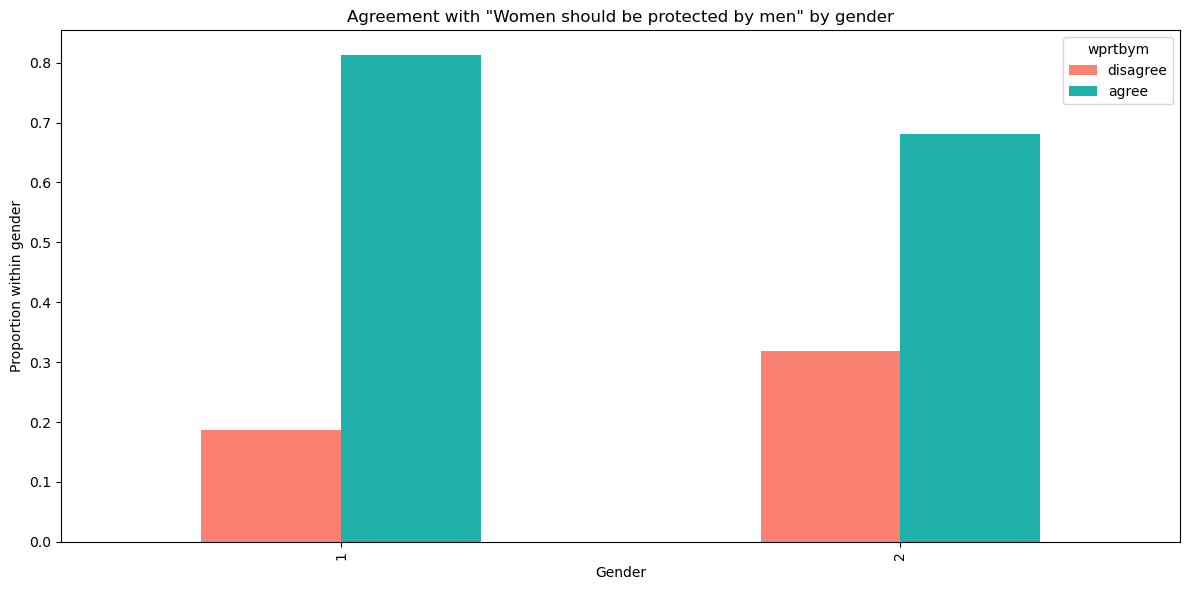

In [29]:
gndr_ct = pd.crosstab(X_train['gndr'], y_train, normalize='index')

gndr_ct.columns = ['disagree', 'agree']

ax = gndr_ct.plot(kind='bar', figsize=(12, 6), color=['salmon', 'lightseagreen'])
ax.set_xlabel('Gender')
ax.set_ylabel('Proportion within gender')
ax.set_title('Agreement with "Women should be protected by men" by gender')
plt.legend(title='wprtbym')
plt.tight_layout()
plt.show()

In the gender plot, both groups show majority agreement, but the proportions differ: Gender code 1 (men) has around 80% agree and 20% disagree. Gender code 2 (women) has a lower agreement rate, roughly 70% agree and 30% disagree. This indicates that men are more likely than women to support the statement, which fits the idea that the norm “women should be protected by men” is more endorsed by the group cast as protectors.

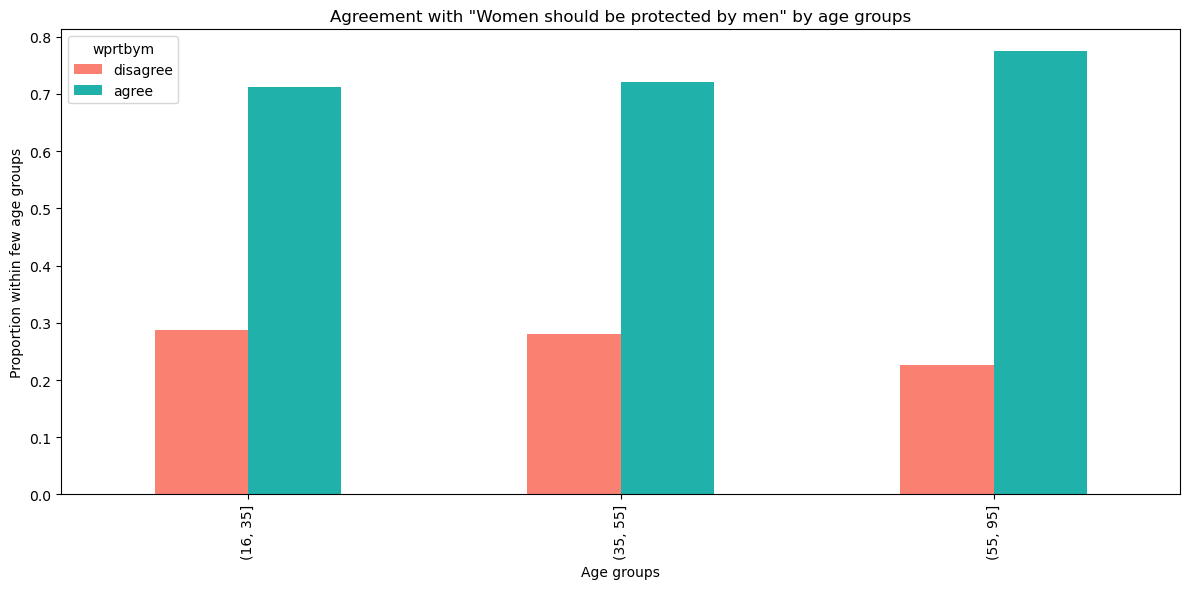

In [30]:
age_ct = pd.crosstab(pd.cut(X_train['age'], [16,35,55,95]), y_train, normalize='index')

age_ct.columns = ['disagree', 'agree']

ax = age_ct.plot(kind='bar', figsize=(12, 6), color=['salmon', 'lightseagreen'])
ax.set_xlabel('Age groups')
ax.set_ylabel('Proportion within few age groups')
ax.set_title('Agreement with "Women should be protected by men" by age groups')
plt.legend(title='wprtbym')
plt.tight_layout()
plt.show()

Across age bands (16–35, 35–55, 55–95), agreement is high in all groups but shows a mild upward trend with age: Young and middle‑aged groups have about 71–72% agreement. The oldest group (55–95) has the highest agreement, close to 78%, and the lowest disagreement. This matches the earlier correlation: older respondents are somewhat more supportive of the traditional protection norm than younger ones.

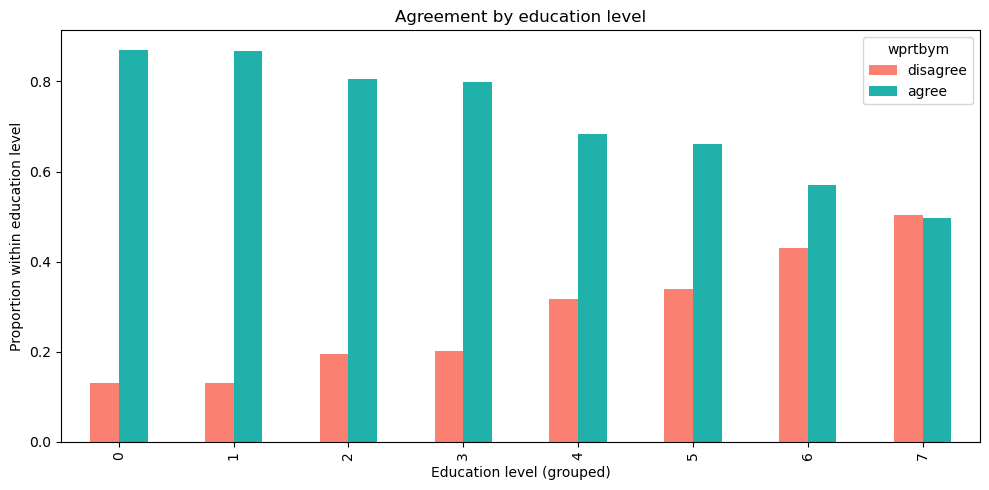

In [ ]:
# Divide education levels by common degrees
edu_map = {
    0: 0, 1: 0,  # 0 (not completed ISCED 1), 1 (other / unspecified)
    113: 1,      # Primary 113 (ISCED 1)
    129: 2, 212: 2, 213: 2, 221: 2, 222: 2, 223: 2,   # Lower secondary (ISCED 2)
    229: 3, 311: 3, 312: 3, 313: 3, 321: 3, 322: 3, 323: 3, # Upper secondary (ISCED 3)
    412: 4, 413: 4, 421: 4, 422: 4, 423: 4, # Post-secondary non‑tertiary (ISCED 4)
    510: 5, 520: 5, 610: 5, 620: 5, # Short/medium tertiary (BA or equivalent)
    710: 6, 720: 6, # Long tertiary (MA or equivalent)
    800: 7 # Doctoral
}

X_train['edu_group'] = X_train['edulvlb'].map(edu_map)

edu_ct = pd.crosstab(X_train['edu_group'], y_train, normalize='index')
edu_ct.columns = ['disagree', 'agree']

ax = edu_ct.plot(kind='bar', figsize=(10,5), color=['salmon', 'lightseagreen'])
ax.set_xlabel('Education level (grouped)')
ax.set_ylabel('Proportion within education level')
ax.set_title('Agreement by education level')
plt.legend(title='wprtbym')
plt.tight_layout()


For low education levels (0–2: below primary, primary, lower secondary), agreement is very high: around 80–90% agree and only 10–20% disagree. As education increases, the agreement share declines and disagreement rises. At the highest levels (6–7: long tertiary and doctorate), agreement and disagreement are almost balanced, with disagreement around 45–50%. This suggests a clear gradient: higher education is associated with weaker support for the protection statement, while lower education groups tend to endorse it more strongly.

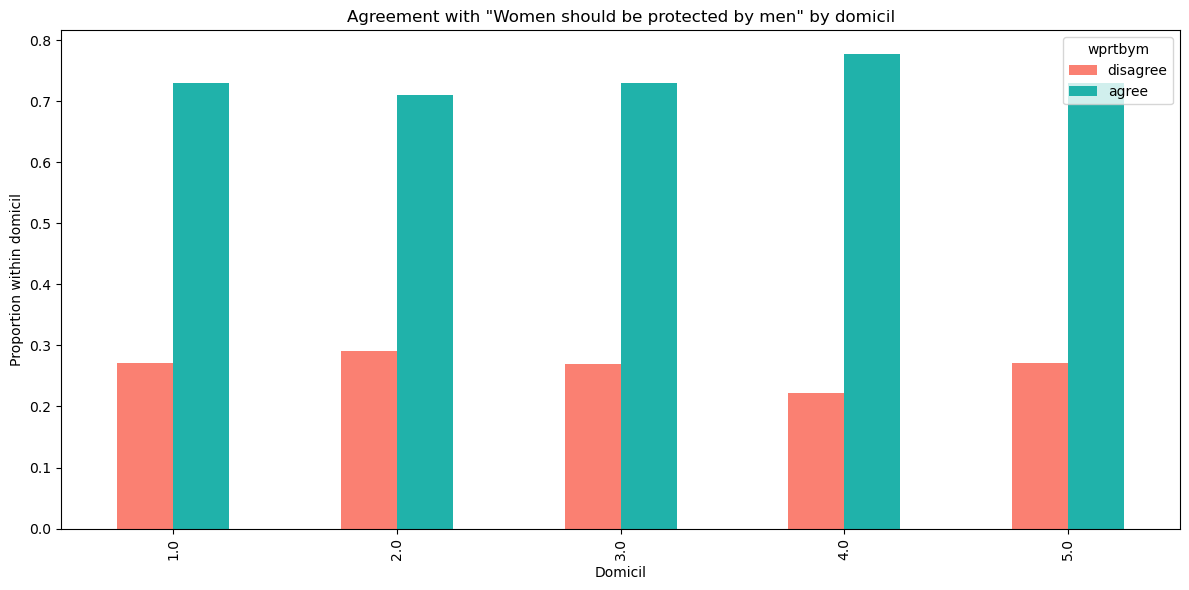

In [32]:
domicil_ct = pd.crosstab(X_train['domicil'], y_train, normalize='index')

domicil_ct.columns = ['disagree', 'agree']

ax = domicil_ct.plot(kind='bar', figsize=(12, 6), color=['salmon', 'lightseagreen'])
ax.set_xlabel('Domicil')
ax.set_ylabel('Proportion within domicil')
ax.set_title('Agreement with "Women should be protected by men" by domicil')
plt.legend(title='wprtbym')
plt.tight_layout()
plt.show()

Agreement is relatively stable across domicile categories (1–5), always around 70–78%. There is only a weak urban‑rural gradient: rural respondents are marginally more likely to agree with the statement, but differences by residence are small compared to those by education or gender.

### 3. Feature engineering 

In this section we use the insights from Exploratory Data Analysis section to engineer the features of our dataset. During the EDA and missing data imputation process some of the steps have already implemented. 

**Variables recoding**<br>
The target variable 'wprtbym' capturing agreement with the statement “Women should be protected by men” is recoded into a binary outcome: responses 1 (“agree strongly”) and 2 (“agree”) are grouped as agree, responses 4 (“disagree”) and 5 (“disagree strongly”) are grouped as disagree, while category 3 (“neither agree nor disagree”) is treated as missing and excluded from the target definition.

**Creating new derived features**<br>
We introduce a new feature 'age' by substracting the survey participant year of birth from the current year: 'age' = current_year - 'yrbrn'. <br>
In addition, respondents were assigned to broad 'age' groups (e.g. 16–35, 35–55, 55–95) to capture possible non‑linear age effects and to facilitate subgroup analyses in the descriptive plots. <br>
To obtain a more interpretable and parsimonious measure of schooling, the detailed ISCED education codes are collapsed into a new ordered 'edu_group' variable, representing broader levels such as below primary, primary, lower secondary, upper secondary, post‑secondary non‑tertiary, and several tiers of tertiary education.
 
**One-hot encoding**<br>
Categorical features such as 'cntry' and 'domicil' are converted into dummy variables using one-hot encoding. This allows models to interpret category membership without assuming ordinality.

**Drop**<br> 
Based on EDA results, column 'marsts' (legal marital status) and 'chldhhe' (ever had children living in household) are dropped, since they have quite a big share of missing values. Columns 'yrbrn' (year of birth) and 'edulvlb' (Highest level of education) are dropped since they are used to create variables 'age' and 'edu_group' and later don't have any explanatory power. 

In [33]:
age_bins   = [16, 35, 55, 95]          # inclusive ranges: (16,35], (35,55], (55,95]
age_labels = ['16–35', '35–55', '55–95']

X_train['age_group'] = pd.cut(
    X_train['age'], bins=age_bins, labels=age_labels,
    right=True, include_lowest=True
)

In [34]:
onehot_cols = ['cntry','domicil', 'age_group']
X_train = pd.get_dummies(X_train, columns=onehot_cols, prefix=onehot_cols, drop_first=False)

In [35]:
print(X_train.columns)

Index(['happy', 'sclmeet', 'aesfdrk', 'health', 'rlgblg', 'rlgatnd', 'dscrgnd',
       'likrisk', 'mascfel', 'femifel', 'impbemw', 'gndr', 'edulvlb', 'pdwrk',
       'wkhtot', 'age', 'edu_group', 'cntry_AT', 'cntry_BE', 'cntry_CH',
       'cntry_CY', 'cntry_DE', 'cntry_ES', 'cntry_FI', 'cntry_FR', 'cntry_GB',
       'cntry_GR', 'cntry_HR', 'cntry_HU', 'cntry_IE', 'cntry_IS', 'cntry_IT',
       'cntry_LT', 'cntry_NL', 'cntry_NO', 'cntry_PL', 'cntry_PT', 'cntry_RS',
       'cntry_SE', 'cntry_SI', 'cntry_SK', 'domicil_1.0', 'domicil_2.0',
       'domicil_3.0', 'domicil_4.0', 'domicil_5.0', 'age_group_16–35',
       'age_group_35–55', 'age_group_55–95'],
      dtype='object')


**Apply changes and features updates on the test set**

In [36]:
# add edu_group
X_test['edu_group']  = X_test['edulvlb'].map(edu_map)

# add age group
X_test['age_group'] = pd.cut(
    X_test['age'], bins=age_bins, labels=age_labels,
    right=True, include_lowest=True
)

# One-hot encode variables
X_test = pd.get_dummies(X_test, columns=onehot_cols, prefix=onehot_cols, drop_first=False)
print(X_test.columns)

Index(['happy', 'sclmeet', 'aesfdrk', 'health', 'rlgblg', 'rlgatnd', 'dscrgnd',
       'likrisk', 'mascfel', 'femifel', 'impbemw', 'gndr', 'edulvlb', 'pdwrk',
       'wkhtot', 'age', 'edu_group', 'cntry_AT', 'cntry_BE', 'cntry_CH',
       'cntry_CY', 'cntry_DE', 'cntry_ES', 'cntry_FI', 'cntry_FR', 'cntry_GB',
       'cntry_GR', 'cntry_HR', 'cntry_HU', 'cntry_IE', 'cntry_IS', 'cntry_IT',
       'cntry_LT', 'cntry_NL', 'cntry_NO', 'cntry_PL', 'cntry_PT', 'cntry_RS',
       'cntry_SE', 'cntry_SI', 'cntry_SK', 'domicil_1.0', 'domicil_2.0',
       'domicil_3.0', 'domicil_4.0', 'domicil_5.0', 'age_group_16–35',
       'age_group_35–55', 'age_group_55–95'],
      dtype='object')


**Features scaling**<br>
In order to make all models work properly with our data, we also need to create dataset with scaled features.

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

### 4. Modeling 

Given the dataset and  our project goals, we want to keep variety and avoid redundancy. A set of the following 5 models would work well: Logistic regression, Decision tree, Random Forest, XGBoost and Ensemble model. The chosen set of models gives a clear progression from simple, interpretable baselines to more powerful nonlinear ensembles, while covering the main algorithmic “families” used for tabular classification.

#### 4.1. Logistic regression 

Logistic regression is a natural baseline for binary classification with mixed numeric and dummy features. It assumes a linear relationship between predictors and the log‑odds of agreement, is fast to train on 20k+ observations, and produces coefficients that can be interpreted substantively (for instance, how education or gender affects the log‑odds of agreeing). <br>

For the logistic regression was used parameter class_weight = 'balanced', because target variable highly skewed toward the agreement class. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. If not given, all classes are supposed to have weight one [7,8].

In [124]:
logreg = LogisticRegression(max_iter=10000, random_state=0, class_weight='balanced') 
logreg.fit(X_train_scaled, y_train)

# Generate predictions
y_pred_train = logreg.predict(X_train_scaled) 
y_pred_test = logreg.predict(X_test_scaled) # class predictions (0 or 1)
y_proba_test = logreg.predict_proba(X_test_scaled)[:, 1] # probability estimates for the positive class (class 1)

# Calculate training metric
print('Training Set Metrics')
print(f'Accuracy : {accuracy_score(y_train, y_pred_train) * 100:.3f}')
print(f'F1-score : {f1_score(y_train, y_pred_train) * 100:.3f}')

# Calculate test metric
print('Test Set Metrics')
logreg_acc_test = accuracy_score(y_test, y_pred_test) * 100
logreg_prec_test = precision_score(y_test, y_pred_test) * 100
logreg_rec_test = recall_score(y_test, y_pred_test) * 100
logreg_f1_test = f1_score(y_test, y_pred_test) * 100
logreg_auc_test = roc_auc_score(y_test, y_proba_test) * 100 
logreg_clsf_rep = classification_report(y_test, y_pred_test, output_dict=True)

print(f'Accuracy : {logreg_acc_test:.3f}%')
print(f'Precision: {logreg_prec_test:.3f}%')
print(f'Recall   : {logreg_rec_test:.3f}%')
print(f'F1-score : {logreg_f1_test:.3f}%')
print(f'ROC AUC  : {logreg_auc_test :.3f}%')

print('Classification report (Test Set):')
print(classification_report(y_test, y_pred_test))


Training Set Metrics
Accuracy : 72.915
F1-score : 79.981
Test Set Metrics
Accuracy : 72.910%
Precision: 88.856%
Recall   : 72.749%
F1-score : 80.000%
ROC AUC  : 80.914%
Classification report (Test Set):
              precision    recall  f1-score   support

         0.0       0.48      0.73      0.58      1420
         1.0       0.89      0.73      0.80      4143

    accuracy                           0.73      5563
   macro avg       0.68      0.73      0.69      5563
weighted avg       0.78      0.73      0.74      5563



The model achieved an overall accuracy of 72.91% on the test set. Crucially, the training and test metrics are nearly identical, with an accuracy of 72.915% and 72.910% respectively, confirming that the model exhibits strong generalization and is not overfitting to the training data. The ROC AUC of 80.914% suggests the model has good discriminatory power and is effective at ranking observations by their probability of belonging to the positive class (1.0). <br>
Taking first the minority class (0.0, disagree). Looking at the Recall value, the model successfully identified 73% of all actual minority class cases. This high recall indicates the class_weight='balanced' parameter achieved its goal of preventing the model from ignoring the less frequent class. Next, taking Precision value, when the model predicted an observation belonged to class 0.0, it was correct only 48% of the time. This lower precision is the main sacrifice made to boost recall. The F1-score represents the harmonic mean of precision and recall for the minority class, 0.58, indicating a moderate overall effectiveness in predicting the less frequent outcome. <br>
Taking now the majority class (1.0, agree), the model is highly accurate when it predicts the positive class, with 89% of those predictions being correct. The model identified 73% of all actual positive cases. The F1-score is strong, 0.80,  for the majority class, indicating reliable predictive performance for the most common outcome.

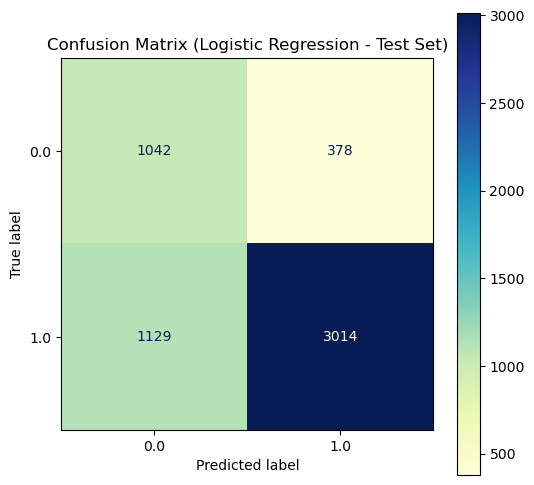

In [39]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logreg.classes_)

fig, ax = plt.subplots(figsize=(6, 6))
cm_display.plot(ax=ax, cmap='YlGnBu')
plt.title('Confusion Matrix (Logistic Regression - Test Set)')
plt.show()

The Confusion Matrix  provides a visual breakdown of the trade-off. True Negatives (TN) is 1042 (Correctly predicted 0.0). This number is high, reflecting the 73% Recall for class 0.0.True Positives (TP) is 3014 (Correctly predicted 1.0). False Negatives (FN) is 1129 (Predicted 0.0, but was actually 1.0). This high number of misses for the majority class explains the drop in Recall for class 1.0 (around 27%).False Positives (FP) is 378 (Predicted 1.0, but was actually 0.0). This relatively low number of Type I errors contributes to the high Precision for class 1.0. <br>
In summary, the use of class_weight='balanced' successfully re-calibrated the Logistic Regression model. It created a model with balanced recall across both classes (both are near 73%) at the cost of overall accuracy and minority-class precision. The resulting performance is a robust baseline for an imbalanced classification task, as the model demonstrates reasonable predictive ability for both outcomes.

In [40]:
coefficients = logreg.coef_[0]

feature_names = X_train.columns # to retrive the columns names
odds_ratios = np.exp(coefficients)

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds Ratio' : odds_ratios
})

print('Feature Importance (Coefficient and Odds Ratio):')
print(feature_importance.sort_values(by='Coefficient', ascending=False))

Feature Importance (Coefficient and Odds Ratio):
            Feature  Coefficient  Odds Ratio
37         cntry_RS     0.562546    1.755135
39         cntry_SI     0.426768    1.532297
10          impbemw     0.283055    1.327179
27         cntry_HR     0.254963    1.290414
40         cntry_SK     0.236628    1.266969
35         cntry_PL     0.140688    1.151066
2           aesfdrk     0.119585    1.127030
23         cntry_FI     0.101110    1.106398
15              age     0.079713    1.082976
8           mascfel     0.070636    1.073191
17         cntry_AT     0.069635    1.072116
21         cntry_DE     0.050960    1.052280
3            health     0.046292    1.047380
47  age_group_35–55     0.033902    1.034483
46  age_group_16–35     0.031221    1.031714
44      domicil_4.0     0.025166    1.025485
12          edulvlb     0.020959    1.021180
14           wkhtot     0.019504    1.019695
45      domicil_5.0     0.011984    1.012057
20         cntry_CY     0.000982    1.000983
0     

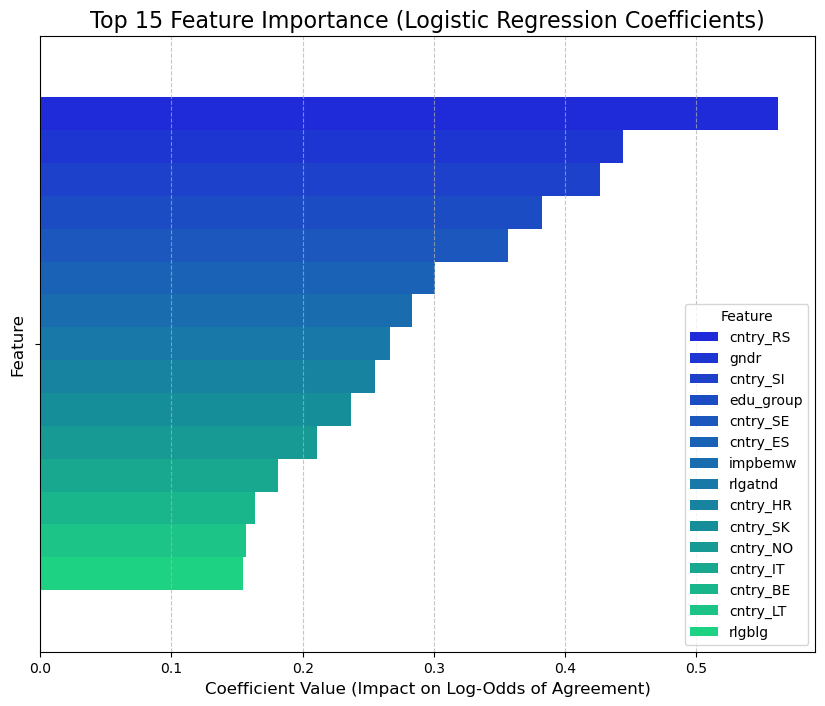

In [41]:
# Calculate absolute values to separate the magnitude (importance) of a feature from its direction (sign)
feature_importance['Absolute_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    x='Absolute_Coefficient', hue='Feature', data=feature_importance.head(15), legend=True,  palette='winter')

plt.title(f'Top 15 Feature Importance (Logistic Regression Coefficients)', fontsize=16)
plt.xlabel('Coefficient Value (Impact on Log-Odds of Agreement)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Let's analyze top 5 most important features by magnitude. Note: the plot uses the absolute coefficient value for ranking. <br>

From the coefficients, odds ratios, and plot results, we can see that 'cntry_RS' (Serbia) is the highest predictor of agreement: the coefficient is +0.563, the odds ratio is 1.755, and the direction is positive. A respondent being from Serbia is associated with a 75.5% increase in the odds of agreeing with the statement, making it the strongest pro-agreement factor. The second strongest predictor of disagreement is 'gndr'. The coefficient is -0.444, the odds ratio is 0.641, and the direction is negative. Since the 'gndr' variable is encoded (Male=1, Female=2), an increase in the value (moving toward female) is associated with a 35.9% decrease in the odds of agreement. The next very strong predictor of agreement is 'cntry_SI' (Slovenia), associated with a 53.2% increase in the odds of agreeing. This variable also has a positive direction, with a coefficient of +0.427. Another strong predictor of disagreement is 'edu_group'. The coefficient is -0.382, the odds ratio is 0.682, and the direction is negative. High education strongly predicts disagreement, associated with a 31.8% decrease in the odds of agreement. The last predictor from the top 5 most important features is also a strong predictor of disagreement, 'cntry_SE' (Sweden): the coefficient is -0.356, the odds ratio is 0.700, and the direction is negative. Being from Sweden is associated with a 30.0% decrease in the odds of agreement, confirming its status as a core anti-agreement factor. We also can observe that the strong presence of country indicators in the Logistic Regression top 15 confirms their role as macro-level structural predictors. The single largest linear shift in the odds of agreeing or disagreeing comes from changing the respondent's national context. <br>

We can indicate several factors strongly predicting agreement (odds ratios > 1). Being from a country like Serbia, Slovenia, Slovakia, Croatia, and Poland is highly associated with agreement. Additionally, importance of being man/woman ('impbemw') positively predicts agreement. <br>

On the other hand, we can indicate several factors strongly predicting disagreement (odds ratios < 1). Moving toward the female end of the gender scale ('gndr') is the strongest individual predictor of disagreement. Higher edu_group values strongly predict disagreement. Being from country like Sweden, Norway, Belgium, Spain or Italy is a strong predictor of disagreement. Religious attendance ('rlgatnd') negatively predicts agreement. <br>

To sum up, the attitude is primarily a battle between cultural/national tradition (pro-agreement) and progressive individual characteristics (anti-agreement), with gender, education level, and specific country as the three pillars of prediction.

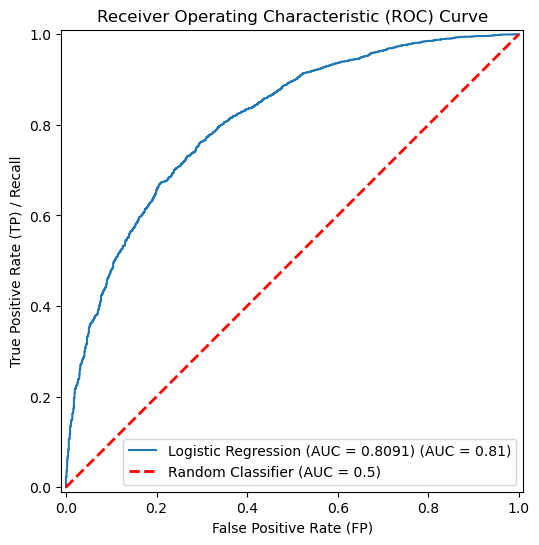

In [42]:
# AUC-ROC Curve 
# Calculate ROC curve metrics (False Positive Rate, True Positive Rate, Thresholds)
FP, TP, thresholds = roc_curve(y_test, y_proba_test)
roc_auc = auc(FP, TP)

fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(logreg, X_test_scaled, y_test, ax=ax, name=f"Logistic Regression (AUC = {roc_auc:.4f})")
# Plot the baseline (random classifier)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate (FP)")
plt.ylabel("True Positive Rate (TP) / Recall")
plt.legend(loc="lower right")
plt.show()

#### 4.2. Decision Tree

A single Decision Tree is a simple nonlinear classifier that can capture interactions and threshold effects that logistic regression can't, such as different rules for men and women or for younger vs older respondents. Trees are easy to visualize (splits on education, gender, age), so they are useful to show how the model “thinks”, even though they tend to overfit and thus provide a contrast to the more stable ensembles. <br>
For the Decision tree model we not use scaled dataset. Unlike Logistic Regression or KNN, Decision Trees don't care about the scale of the data. Tree-based models such as Decision Tree use a flowchart-like structure to split data based on the data. It would then make decisions by going down the tree until it reaches a terminal node (leaf) to make a decision. It decides where to split by using the Gini Index or Entropy [12].

In [128]:
#  Define thу parameters for Grid search [9,10]
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, 15, 20, None],  # None means unlimited depth
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 3, 4, 5, 10],
    'class_weight': ['balanced'] # to handle the imbalance
}

# Define the scoring metric for optimization
# F1-macro is best for imbalanced data as it averages the F1-score of both classes [9].
scoring_metric = make_scorer(f1_score, average='macro')


# Run Grid search (with Cross-Validation) 
# Decision Tree Classifier (use random_state for reproducibility) [1,2,11]
dtc = DecisionTreeClassifier(random_state=42)

# Set up the Grid Search with 5-fold Cross-Validation [10]
grid_search = GridSearchCV(
    estimator=dtc, 
    param_grid=param_grid, 
    scoring=scoring_metric, 
    cv=5, 
    verbose=1, 
    n_jobs=-1  # Use all available cores
)

# Fit the grid search to the scaled training data
print('Starting Grid Search')
grid_search.fit(X_train, y_train)

# Get the best model
best_dtc = grid_search.best_estimator_

print(f'Best Parameters Found: {grid_search.best_params_}')
print(f'Best CV Score (F1-Macro): {grid_search.best_score_:.4f}')


# Evaluate the Best Model on the Test Set 
y_pred_test = best_dtc.predict(X_test)
y_proba_test = best_dtc.predict_proba(X_test)[:, 1]
dt_clsf_rep = classification_report(y_test, y_pred_test, output_dict=True)

print('--------------------------------------------')
print('Test Set Metrics')
print(classification_report(y_test, y_pred_test))

# AUC-ROC Score
dt_auc_roc = roc_auc_score(y_test, y_proba_test)
print(f'ROC AUC Score: {dt_auc_roc:.4f}')

Starting Grid Search
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Parameters Found: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV Score (F1-Macro): 0.6489
--------------------------------------------
Test Set Metrics
              precision    recall  f1-score   support

         0.0       0.42      0.65      0.51      1420
         1.0       0.85      0.69      0.76      4143

    accuracy                           0.68      5563
   macro avg       0.64      0.67      0.64      5563
weighted avg       0.74      0.68      0.70      5563

ROC AUC Score: 0.6902


The Decision Tree model results are not good comparing to the baseline Logistic Regression model. It's performing significantly worse in terms of overall predictive power (lower ROC AUC: 80.91% vs. 69.02%) and generalization ability (lower F1-Macro: 0.69 vs. 0.64). <br>
The model selected a relatively deep tree (max_depth: 15) and minimal constraints (min_samples_leaf: 1, min_samples_split: 2), meaning it's still a very complex model. However, the best CV Score, 0.6489, is close to the Test Set F1-Macro (0.64), indicating that the cross-validation was successful and the model is generalizing as expected, but its inherent predictive capability is just lower than the Logistic Regression model. <br>
The Decision Tree didn't successfully leverage its complexity to find better patterns. It performed worse on both classes' Recall and Precision compared to the Logistic Regression, meaning it's missing more true positives and more true negatives.

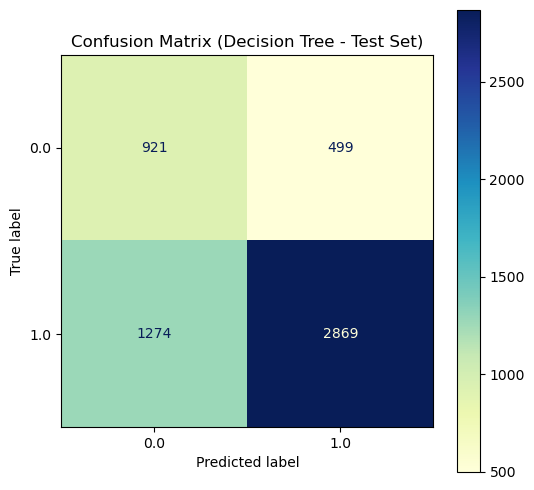

In [44]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_dtc.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='YlGnBu')
plt.title('Confusion Matrix (Decision Tree - Test Set)')
plt.show()

The Confusion Matrix confirms the weak performance compared to the balanced Logistic Regression: the Decision Tree has fewer True Negatives (921 vs. 1042) and more False Negatives (1274 vs. 1129). This indicates the Decision Tree is less effective at capturing the minority class and is making more errors on the majority class than the simpler, linearly-separated Logistic Regression model.

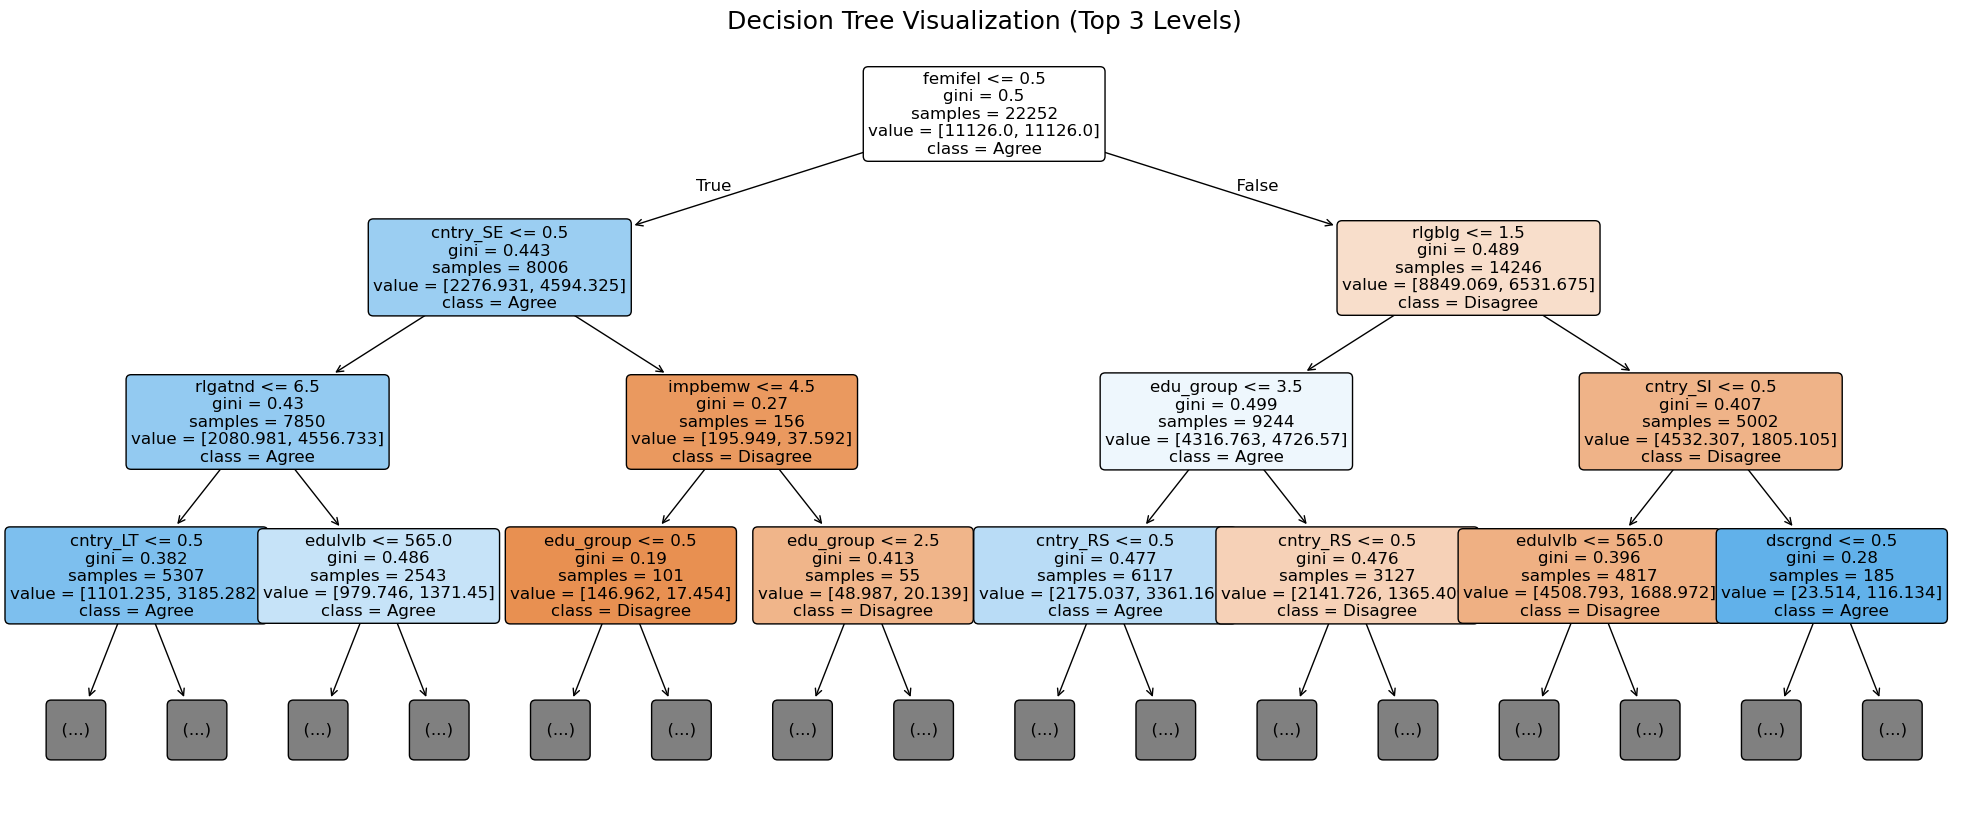

In [45]:
feature_names = X_train.columns.tolist()

# Plot the tree
plt.figure(figsize=(25, 10))
plot_tree(
    best_dtc, 
    max_depth=3,                  # Limit depth for readability
    feature_names=feature_names, 
    class_names=['Disagree', 'Agree'],    
    filled=True,                  
    rounded=True,                
    fontsize=12                  
)

plt.title("Decision Tree Visualization (Top 3 Levels)", fontsize=18)
plt.show()

In [46]:
# Export the rules for the Decision Tree
tree_rules = export_text(best_dtc, feature_names=feature_names)
print(tree_rules)

|--- femifel <= 0.50
|   |--- cntry_SE <= 0.50
|   |   |--- rlgatnd <= 6.50
|   |   |   |--- cntry_LT <= 0.50
|   |   |   |   |--- cntry_NO <= 0.50
|   |   |   |   |   |--- cntry_RS <= 0.50
|   |   |   |   |   |   |--- edulvlb <= 665.00
|   |   |   |   |   |   |   |--- cntry_SI <= 0.50
|   |   |   |   |   |   |   |   |--- cntry_ES <= 0.50
|   |   |   |   |   |   |   |   |   |--- cntry_IS <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- cntry_NL <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- cntry_NL >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |--- cntry_IS >  0.50
|   |   |   |   |   |   |   |   |   |   |--- age <= 57.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |   |   |--- age >  57.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   

Let's investigate the first levels of the tree. <br>
We can see that the root node is a 'femifel' variable (the gender identity filter). The tree immediately separates the population based on femininity. Since the variable is likely on a scale of 0 (Not at all feminine) to 6 (Very feminine), the split at 0.50 isolates respondents who explicitly selected "0 - Not at all feminine". True on the left, it means "It is True that this person selected 'Not at all feminine'. This effectively acts as a proxy for gender. The "Left Branch" represents the group that identifies as not feminine (mostly men), and the "Right Branch" represents those with any degree of femininity (mostly women). <br>
If the respondent is in the "Not Feminine" group, the tree prioritizes nationality and religious attendance. We can see that for men outside of Sweden, religious attendance is a massive predictor of their views on protecting women. For Swedish men, personal values ('impbemw', importance of beeing woman/man) matter more. <br>
If the respondent has any degree of femininity ('femifel' > 0.5), the tree prioritizes religious belonging. It splits religious women by education level. And later in the deeper split, the tree checks the nationality (belonging to Serbia or Croatia). For the persons who are not religious belonging, the tree checks the nationality (specifically Slovenian).It isolates Slovenia as a specific case, then looks at Spain (cntry_ES) or education. <br>
We can also notice significant splits within the deep tree layers: 'age' and 'wkhtot' (working hours). <br>
Overall, the decision tree reveals that Gender Identity (proxied by femininity) is the primary driver of views on "Women should be protected by men". For men (low femininity), cultural context (nationality) and religious attendance (behavior) are the main predictors. For women (high femininity),  religious belonging (identity) and education level are the main predictors. Division by generations, where specific age cut-offs appear frequently deep in the tree, showing that generation plays a strong role after gender and religion are accounted for.

In [47]:
def gini_impurity(y_node):
    _, counts = np.unique(y_node, return_counts=True)
    probs = counts / counts.sum()
    return 1.0 - np.sum(probs ** 2)

# Gini at the root of the fitted best_dtc on TRAIN
root_node_indices = best_dtc.apply(X_train) == 0
gini_root = gini_impurity(y_train)
print("Gini impurity at root:", gini_root)

Gini impurity at root: 0.3801146567859359


Root Gini (0.3801) perfectly matches the class imbalance we established earlier (roughly 74.5% vs 25.5%). A balanced 50/50 dataset would have a Gini of 0.5, so 0.38 confirms the data is moderately imbalanced.

In [48]:
def gini_split_gain(y, split_mask):
    y_parent = y
    y_left   = y[split_mask]
    y_right  = y[~split_mask]
    g_parent = gini_impurity(y_parent)
    g_left   = gini_impurity(y_left)
    g_right  = gini_impurity(y_right)
    n = len(y_parent)
    nL, nR = len(y_left), len(y_right)
    weighted_child_gini = (nL/n)*g_left + (nR/n)*g_right
    return g_parent - weighted_child_gini

In [49]:
split_mask = X_train['age'] >= 45       
# Recompute gain
gain = gini_split_gain(y_train.values, split_mask.values)
print("Gini gain for split age >= 45:", gain)

# Sanity checks
print("Left size:", split_mask.sum(), "Right size:", (~split_mask).sum())
print("Class proportions left:", y_train[split_mask].mean())
print("Class proportions right:", y_train[~split_mask].mean())
print("Root Gini:", gini_impurity(y_train.values))
print("Left Gini:", gini_impurity(y_train[split_mask].values))
print("Right Gini:", gini_impurity(y_train[~split_mask].values))

Gini gain for split age >= 45: 0.0007235127083778936
Left size: 15049 Right size: 7203
Class proportions left: 0.7579905641570869
Class proportions right: 0.7173399972233792
Root Gini: 0.3801146567859359
Left Gini: 0.3668817376118161
Right Gini: 0.4055266512138831


In [50]:
split_mask = X_train['wkhtot'] >= 40       
# Recompute gain
gain = gini_split_gain(y_train.values, split_mask.values)
print("Gini gain for split worked hours >= 40:", gain)

# Sanity checks
print("Left size:", split_mask.sum(), "Right size:", (~split_mask).sum())
print("Class proportions left:", y_train[split_mask].mean())
print("Class proportions right:", y_train[~split_mask].mean())
print("Root Gini:", gini_impurity(y_train.values))
print("Left Gini:", gini_impurity(y_train[split_mask].values))
print("Right Gini:", gini_impurity(y_train[~split_mask].values))

Gini gain for split worked hours >= 40: 0.003161375802539723
Left size: 14154 Right size: 8098
Class proportions left: 0.77490462060195
Class proportions right: 0.6922696962212892
Root Gini: 0.3801146567859359
Left Gini: 0.34885489914339596
Right Gini: 0.4260647278299463


In [51]:
split_mask = X_train['impbemw'] >= 5       
# Recompute gain
gain = gini_split_gain(y_train.values, split_mask.values)
print("Gini gain for split importance of beeing man/woman >= 5:", gain)

# Sanity checks
print("Left size:", split_mask.sum(), "Right size:", (~split_mask).sum())
print("Class proportions left:", y_train[split_mask].mean())
print("Class proportions right:", y_train[~split_mask].mean())
print("Root Gini:", gini_impurity(y_train.values))
print("Left Gini:", gini_impurity(y_train[split_mask].values))
print("Right Gini:", gini_impurity(y_train[~split_mask].values))

Gini gain for split importance of beeing man/woman >= 5: 0.009482374164196838
Left size: 14145 Right size: 8107
Class proportions left: 0.7969600565570873
Class proportions right: 0.6538793635130135
Root Gini: 0.3801146567859359
Left Gini: 0.3236294496192229
Right Gini: 0.4526422829696597


In [52]:
split_mask = X_train['happy'] >= 5        

# Recompute gain
gain = gini_split_gain(y_train.values, split_mask.values)
print("Gini gain for split happy >= 5:", gain)

# Sanity checks
print("Left size:", split_mask.sum(), "Right size:", (~split_mask).sum())
print("Class proportions left:", y_train[split_mask].mean())
print("Class proportions right:", y_train[~split_mask].mean())
print("Root Gini:", gini_impurity(y_train.values))
print("Left Gini:", gini_impurity(y_train[split_mask].values))
print("Right Gini:", gini_impurity(y_train[~split_mask].values))

Gini gain for split happy >= 5: 0.00041673084139715044
Left size: 20888 Right size: 1364
Class proportions left: 0.7411432401378782
Class proportions right: 0.8013196480938416
Root Gini: 0.3801146567859359
Left Gini: 0.3836998754716112
Right Gini: 0.31841293934520687


In [53]:
split_mask = X_train['cntry_SE'] > 0        

# Recompute gain
gain = gini_split_gain(y_train.values, split_mask.values)
print("Gini gain for country is Sweden >= 0:", gain)

# Sanity checks
print("Left size:", split_mask.sum(), "Right size:", (~split_mask).sum())
print("Class proportions left:", y_train[split_mask].mean())
print("Class proportions right:", y_train[~split_mask].mean())
print("Root Gini:", gini_impurity(y_train.values))
print("Left Gini:", gini_impurity(y_train[split_mask].values))
print("Right Gini:", gini_impurity(y_train[~split_mask].values))

Gini gain for country is Sweden >= 0: 0.014963713268835666
Left size: 630 Right size: 21622
Class proportions left: 0.23809523809523808
Class proportions right: 0.7595967070576265
Root Gini: 0.3801146567859359
Left Gini: 0.36281179138322006
Right Gini: 0.3652190993696738


The Gini analysis highlighted the overwhelming influence of cultural context, based on the test with some features/variables. The following variables and splits were selected: country = Sweden, age >= 45, working hours >= 40, feeling happiness >= 5, importance of being man/woman >= 5. <br>
The variable cntry_SE (Sweden) yielded the highest Information Gain (0.0150), outperforming gender identity values (0.0095), demographic variables like age (0.0007), happiness (0.0004), and economic factors (worked hours, 0.0032).The split revealed a strong contrast: while approximately 76% of the general population agreed with the statement "Women should be protected by men", only 24% of respondents from Sweden agreed. This suggests that while personal values matter, the macro-societal environment is the dominant factor shaping attitudes toward "friendly" sexism. <br>

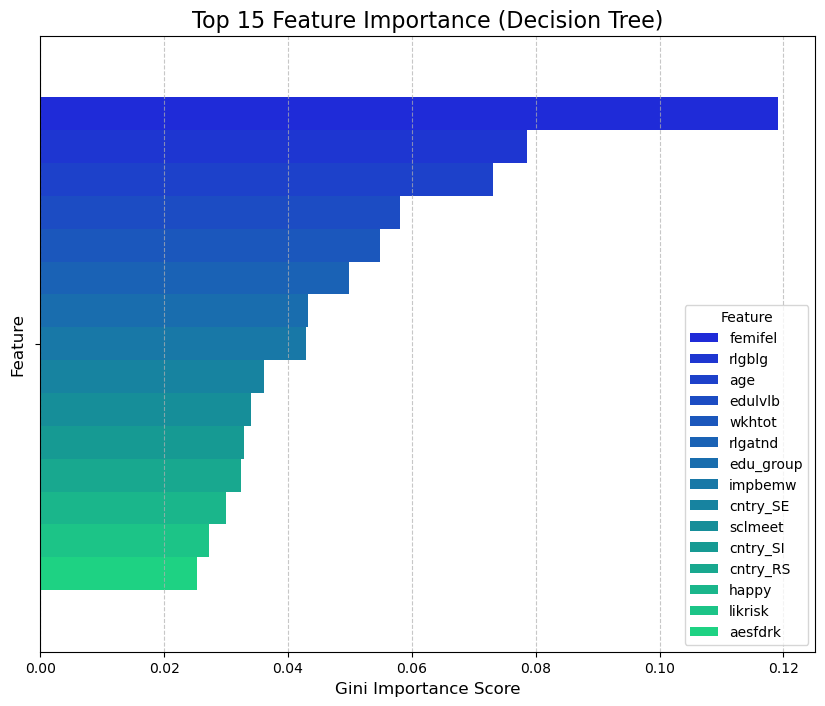

Feature importances (all):
        Feature  Gini Importance
        femifel         0.119191
         rlgblg         0.078541
            age         0.073080
        edulvlb         0.058121
         wkhtot         0.054830
        rlgatnd         0.049894
      edu_group         0.043286
        impbemw         0.042963
       cntry_SE         0.036105
        sclmeet         0.034092
       cntry_SI         0.032929
       cntry_RS         0.032338
          happy         0.030042
        likrisk         0.027182
        aesfdrk         0.025287
         health         0.022920
        mascfel         0.022808
       cntry_ES         0.021915
       cntry_HR         0.019095
       cntry_SK         0.014760
       cntry_LT         0.013144
       cntry_NL         0.010718
           gndr         0.010656
age_group_35–55         0.009877
    domicil_1.0         0.009616
       cntry_NO         0.008716
       cntry_PL         0.008020
       cntry_AT         0.007082
       cntry_FI 

In [54]:
feature_importances = pd.Series(best_dtc.feature_importances_, index=X_train.columns)
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Gini Importance': feature_importances
})

feature_imp_df = feature_imp_df.sort_values(by='Gini Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Gini Importance', hue='Feature', data=feature_imp_df.head(15), legend=True,  palette='winter')

plt.title('Top 15 Feature Importance (Decision Tree)', fontsize=16)
plt.xlabel('Gini Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


print('Feature importances (all):')
print(feature_imp_df.to_string(index=False))

'Femifel' is the dominant predictor. This is by far the most important feature, confirming that gender identity (specifically, how feminine a respondent feels) is the primary lens through which this issue is viewed. It contributes nearly 12% (0.119) to the model's predictive power on its own. This aligns perfectly with the root node of the decision tree. The divide between those who identify as feminine (mostly women) and those who don't (mostly men) is the fundamental split in the data. <br>
Whether a person belongs to a religion (0.0785) is the second most powerful predictor. This suggests that traditional values associated with religious institutions play a massive role in shaping attitudes toward man/woman role and state ("protective" views). <br>
Age is the third strongest driver: (0.0730). This confirms a significant generational gap. Older generations likely hold more traditional views on gender roles compared to younger cohorts, making age a critical differentiator. <br>
Education and working hours are in the top 5 (0.058 and 0.054 respectively), indicating that socio-economic status and daily activity patterns are significant but secondary to identity and values. <br>
While specific countries appear in the top 15, no single country dominates the list like gender or religion does. However, Sweden (cntry_SE) is the highest-ranked country, (0.036), reinforcing its status as a unique cultural outlier with distinct gender norms compared to the rest of the dataset. <br>
Interestingly, gender is way down the list (around 0.01). This proves that femifel (Gender Identity) is a much more precise and powerful predictor for this specific psychological attitude than simple biological sex. The model prefers the nuance of "how feminine you feel" over "are you male or female."

#### 4.3. Random Forest <br>
Random forest is a bagging ensemble of many decision trees, each trained on bootstrap samples with feature subsampling. It greatly reduces the variance and overfitting of a single tree, usually improving predictive performance and robustness on structured survey data. It also provides measures of feature importance, allowing us to discuss which variables (e.g. education, gender, country) are most influential in the ensemble. <br>
For the parameters tuning we decided not to tune all the parameters, becuase of the high computation. We proceed with 500 number of trees, because a higher number of trees usually leads to better performance: it allows the model to generalize better by averaging the predictions of multiple trees. We fix criterion 'gini' because it is faster than 'entropy'. We fix oob_score as 'True' just to have it, but we don't tune it. Finally, we set bootstrap as 'True' to train the model on a random sample of the data making the model more diverse [16-19].

In [ ]:
# Define thу parameters for Grid search [9,10]
# It's not so effective tune all most of the parameters. Keep only the parameters that actually control overfitting vs. underfitting
param_grid = {
    'max_depth': [10, 15, 20, None],  # None means unlimited depth
    'min_samples_split': [2, 10],
    'max_samples' : [0.5, 0.7, None], 
    'max_features' : ['sqrt', 'log2'],
    'min_samples_leaf': [2, 4, 10]
}

# Define the scoring metric for optimization
# F1-macro is best for imbalanced data as it averages the F1-score of both classes [9].
scoring_metric = make_scorer(f1_score, average='macro')


# Run Grid search (with Cross-Validation) 
# Random Forest Classifier (use random_state for reproducibility) [1,2,11]
rndf = RandomForestClassifier(
    n_estimators=500, 
    criterion='gini',
    bootstrap=True,
    oob_score=True,
    class_weight='balanced', # handle imbalance
    random_state=42,
    n_jobs=-1
    )

# Set up the Grid Search with 5-fold Cross-Validation [10]
grid_search = GridSearchCV(
    estimator=rndf, 
    param_grid=param_grid, 
    scoring=scoring_metric, 
    cv=5, 
    verbose=1, 
    n_jobs=-1  
)

# Fit the grid search to the scaled training data
print('Starting Grid Search')
grid_search.fit(X_train, y_train)

# Get the best model
best_rndf = grid_search.best_estimator_

print(f'Best Parameters Found: {grid_search.best_params_}')
print(f'Best CV Score (F1-Macro): {grid_search.best_score_:.4f}')

Starting Grid Search
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters Found: {'max_depth': None, 'max_features': 'log2', 'max_samples': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best CV Score (F1-Macro): 0.7215


In [131]:
oob_accuracy = best_rndf.oob_score_
oob_error = 1 - oob_accuracy

print(f"OOB Accuracy Score: {oob_accuracy:.4f}")
print(f"OOB Error Rate: {oob_error:.4f}")

OOB Accuracy Score: 0.7926
OOB Error Rate: 0.2074


In [132]:
# Evaluate the Best Model on the Test Set 
y_pred_test = best_rndf.predict(X_test)
y_proba_test = best_rndf.predict_proba(X_test)[:, 1]
fr_clsf_rep = classification_report(y_test, y_pred_test, output_dict=True)

print('Test Set Metrics')
print(classification_report(y_test, y_pred_test))

# AUC-ROC Score
rf_auc_roc = roc_auc_score(y_test, y_proba_test)
print(f'ROC AUC Score: {rf_auc_roc:.4f}')

Test Set Metrics
              precision    recall  f1-score   support

         0.0       0.61      0.55      0.58      1420
         1.0       0.85      0.88      0.86      4143

    accuracy                           0.80      5563
   macro avg       0.73      0.72      0.72      5563
weighted avg       0.79      0.80      0.79      5563

ROC AUC Score: 0.8155


For now the test accuracy score is increased by 80%. Additionally, the close alignment between OOB score (79.26%) and test accuracy means the model generalizes reliably and is not overfitting. The best CV score (F1-macro) indicates the optimization was highly successful: 0.7215. The final Test F1-Macro, 0.72, aligns closely with the CV score, further confirming generalization. From ROC AUC highest discriminatory power for now is observed:0.8155. The model is highly effective at ranking the probability of agreement vs. disagreement. We can conclude, that Random Forest performs better for overall predictive performance than Decision Tree and Logistic Regression. <br>
Regarding the Recall and Precision, Random Forest captures 55% of the true minority cases. This is lower than the 73% Recall achieved by the Logistic Regression. The Random Forest prioritized overall accuracy and majority class performance. It is less sensitive to the minority class than the Logistic Regression model. At 0.61, when the Random Forest predicts disagreement (0.0), it's correct 61% of the time. This is a good improvement over the Decision Tree's 0.42 Precision. The Random Forest model performs better at majority performance, predicting agreement with high certainty (Precision 0.85) and capturing most of the actual cases (Recall 0.88).

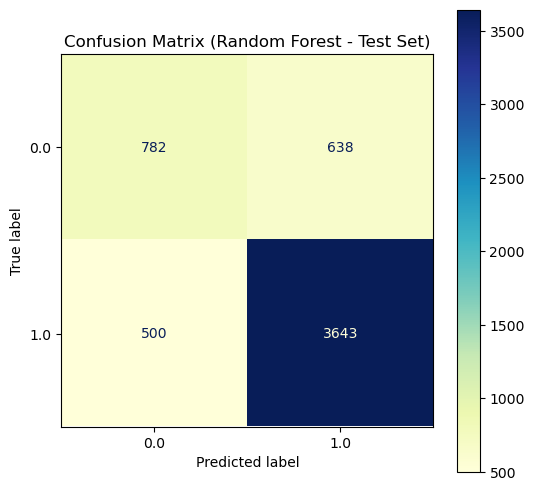

In [58]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rndf.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='YlGnBu')
plt.title('Confusion Matrix (Random Forest - Test Set)')
plt.show()

The Random Forest significantly reduced the number of False Negatives (FN) (missing a true 1.0 case) compared to the Decision Tree (1274 for the Decision Tree and 500 for the Random Forest), resulting in better overall accuracy.

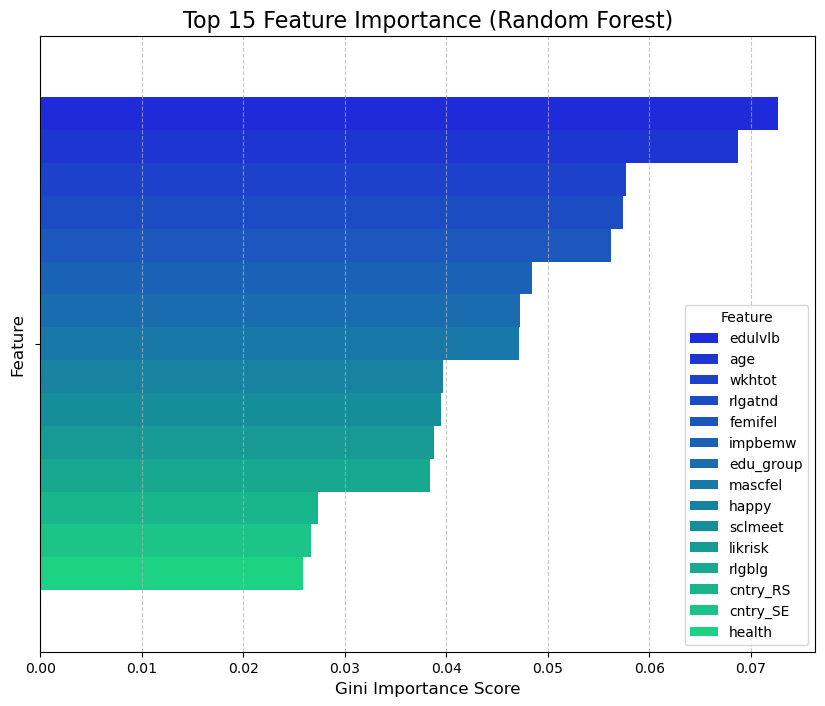

Feature importances (all):
        Feature  Gini Importance
        edulvlb         0.072707
            age         0.068698
         wkhtot         0.057691
        rlgatnd         0.057401
        femifel         0.056194
        impbemw         0.048456
      edu_group         0.047219
        mascfel         0.047169
          happy         0.039654
        sclmeet         0.039489
        likrisk         0.038785
         rlgblg         0.038393
       cntry_RS         0.027359
       cntry_SE         0.026642
         health         0.025872
        aesfdrk         0.024319
           gndr         0.022459
       cntry_SI         0.019217
       cntry_ES         0.017829
       cntry_HR         0.013033
          pdwrk         0.012824
    domicil_4.0         0.011634
       cntry_SK         0.011451
    domicil_3.0         0.010870
    domicil_1.0         0.010512
       cntry_NO         0.009845
       cntry_LT         0.009125
       cntry_IT         0.008841
age_group_55–95 

In [59]:
feature_names = X_train.columns
feature_importances = pd.Series(best_rndf.feature_importances_, index=X_train.columns)
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Gini Importance': feature_importances
})

feature_imp_df = feature_imp_df.sort_values(by='Gini Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Gini Importance', hue='Feature', data=feature_imp_df.head(15), legend=True,  palette='winter')

plt.title('Top 15 Feature Importance (Random Forest)', fontsize=16)
plt.xlabel('Gini Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


print('Feature importances (all):')
print(feature_imp_df.to_string(index=False))

The feature importance analysis for the Random Forest model shows that the predictive power is no longer dominated by a single variable, but is broadly and stably distributed across socio-demographic factors. The Random Forest found that while 'femifel' is the best root split for a single tree, 'education' is consistently the most valuable predictor across all 500 trees when they are forced to use diverse feature subsets. 'Age' and 'education' tend to have complex, stable interactions that a massive ensemble can capture better than a single split. The top 5 features are now dominated by socio-economic/demographic factors: 'education', 'age', 'worked hours', 'frequency of attending religious services'. 'Femifel' is still a vital predictor, but the Random Forest ranks it below socio-economic/demographic variables. The information contained in femifel (gender identity) is highly useful but is shared and slightly thined by other, more general predictors. The influence of country is distributed across many one-hot encoded variables, but Serbia (cntry_RS, 0.0274) and Sweden (cntry_SE, 0.0266) are the highest-ranked specific country codes, reflecting their extreme positions on the attitude scale.

#### 4.4. XGBoost (gradient boosting) <br>
XGBoost represents the boosting family of tree ensembles, where trees are added sequentially to correct errors of previous ones. Gradient‑boosted trees often deliver state‑of‑the‑art performance on tabular datasets with complex, weak, and interacting predictors like ours. Including XGBoost lets us compare bagging vs boosting approaches and see whether focusing on “hard‑to‑predict” observations improves metrics over random forest [20-26].

In [ ]:
# Define thу parameters for Grid search [9,10]
param_grid = {
    'max_depth': [3, 5, 7, 9],  
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma' : [0, 0.1, 0.5], 
    'min_child_weight': [1, 3, 5],
    'reg_lambda' : [0, 1, 10]  # L2 regularization

}


# In binary classification, the scale_pos_weight parameter can be used to address imbalanced datasets. 
# It helps by balancing the positive and negative classes, giving more weight to the minority class. [24-26]
scale_pos_weight_ratio = ((y_train == 0).sum())/ ((y_train == 1).sum()) # here we used negative _class/positive_class

# Define the scoring metric for optimization
# F1-macro is best for imbalanced data as it averages the F1-score of both classes [9].
scoring_metric = make_scorer(f1_score, average='macro')


# Run Grid search (with Cross-Validation) 
# Random Forest Classifier (use random_state for reproducibility) [1,2,11]
xbg_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=500,    # alternatively could be set num_rounds
    subsample=0.8, # to prevent overfitting         
    colsample_bytree=0.8,                       
    booster='gbtree',    
    tree_method='auto',    
    scale_pos_weight=scale_pos_weight_ratio, 
    random_state=42,
    n_jobs=-1
    )

# Set up the Grid Search with 5-fold Cross-Validation [10]
grid_search = GridSearchCV(
    estimator=xbg_clf, 
    param_grid=param_grid, 
    scoring=scoring_metric, 
    cv=5, 
    verbose=1, 
    n_jobs=-1  
)

# Fit the grid search to the scaled training data
print('Starting Grid Search')
grid_search.fit(X_train, y_train)

# Get the best model
best_xgb = grid_search.best_estimator_

print(f'Best Parameters Found: {grid_search.best_params_}')
print(f'Best CV Score (F1-Macro): {grid_search.best_score_:.4f}')

Starting Grid Search
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters Found: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'reg_lambda': 10}
Best CV Score (F1-Macro): 0.7151


The best parameters reveal a model that is both deep and fast. The max depth of 7 confirms the best performance is achieved with a relatively deep but not overly complex tree structure. The 0.1 learning rate is a moderate-to-fast learning rate. The 10 value for the reg_lambda parameter indicates the model required strong L2 regularization to prevent overfitting, which is common in deep boosting models.

In [134]:
# Evaluate the Best Model on the Test Set 
y_pred_test = best_xgb.predict(X_test)
y_proba_test = best_xgb.predict_proba(X_test)[:, 1]
xgb_clsf_rep = classification_report(y_test, y_pred_test, output_dict=True)

print('Test Set Metrics')
print(classification_report(y_test, y_pred_test))

# AUC-ROC Score
xgb_auc_roc = roc_auc_score(y_test, y_proba_test)
print(f'ROC AUC Score: {xgb_auc_roc:.4f}')

Test Set Metrics
              precision    recall  f1-score   support

         0.0       0.54      0.65      0.59      1420
         1.0       0.87      0.81      0.84      4143

    accuracy                           0.77      5563
   macro avg       0.70      0.73      0.71      5563
weighted avg       0.79      0.77      0.77      5563

ROC AUC Score: 0.8112


XGBoost model achieved strong performance metrics, comparable to the ensemble models, and successfully balanced the minority class using the suggested weight tuning strategy. The model achieved  very solid overall accuracy, 77.03%, though slightly lower than the Random Forest's 80.05%. The CV score is closely matched by the final Test F1-Macro (0.71), confirming the model is well-generalized and not overfitting. The ROC AUC score has very strong discriminatory power and is comparable to the other top models (for now it's Random Forest: 0.8155). <br>
XGBoost achieved 65% Recall for the minority class. This is far better than the Random Forest (55%), showing that the scale_pos_weight tuning was highly effective at finding the 0 cases. At 87%, the model is very precise when it predicts the majority class.

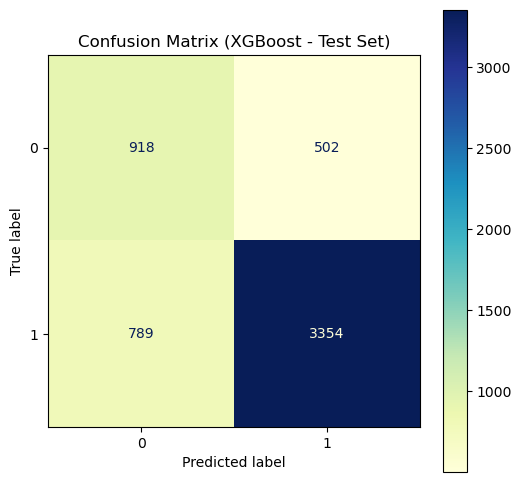

In [62]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgb.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='YlGnBu')
plt.title('Confusion Matrix (XGBoost - Test Set)')
plt.show()

The Confusion Matrix confirms the successful tuning of scale_pos_weight: True Negative number is 918, model found correctly 918 'Disagree' cases. False Negative number is 789, when model misses true 'Agree' cases. This model provides a robust and reliable alternative to the Random Forest, particularly if the ability to correctly identify the minority group is our main issue. The models correctly predicted 3354 respondents would 'Agree', 1.0. Because of the aggressive scale_pos_weight tuning, the model was forced to be cautious about predicting 1.0, which helped reduce False Positive errors. False Positive number is 502. 

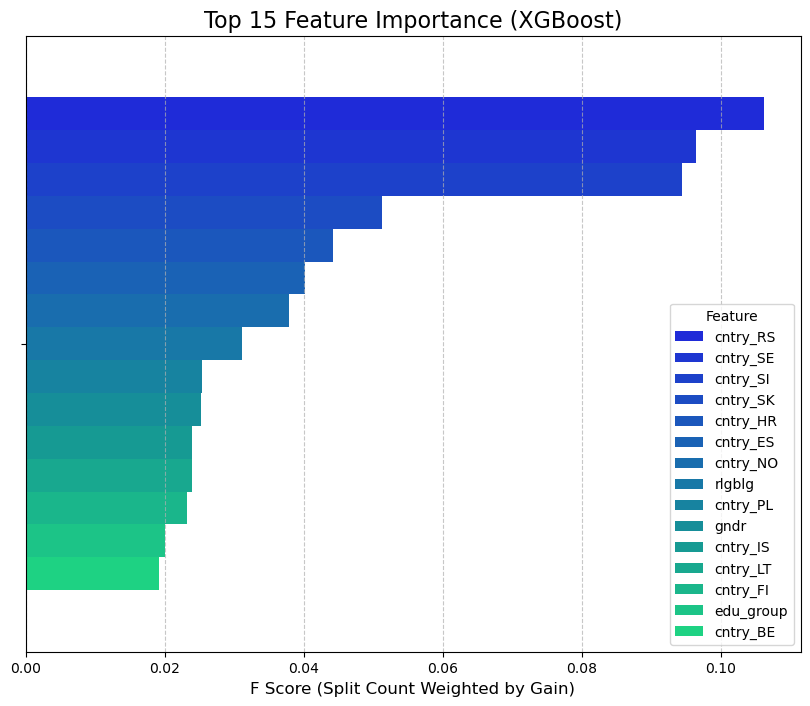

Feature importances (all):
        Feature  Importance
       cntry_RS    0.106169
       cntry_SE    0.096391
       cntry_SI    0.094404
       cntry_SK    0.051270
       cntry_HR    0.044261
       cntry_ES    0.040190
       cntry_NO    0.037955
         rlgblg    0.031113
       cntry_PL    0.025382
           gndr    0.025258
       cntry_IS    0.023949
       cntry_LT    0.023927
       cntry_FI    0.023179
      edu_group    0.020083
       cntry_BE    0.019232
       cntry_NL    0.018345
        femifel    0.017596
       cntry_IT    0.016691
       cntry_AT    0.015191
       cntry_HU    0.014918
       cntry_CH    0.012620
        rlgatnd    0.012387
       cntry_DE    0.012333
        edulvlb    0.012151
        impbemw    0.010887
        dscrgnd    0.010566
       cntry_GR    0.009756
       cntry_PT    0.009582
        mascfel    0.009504
       cntry_CY    0.009484
       cntry_IE    0.009234
       cntry_GB    0.008872
       cntry_FR    0.008626
    domicil_1.0    0.

In [63]:
# XGBoost uses the fitted model's own feature_importances_ property
importance_scores = best_xgb.feature_importances_
feature_names = X_train.columns

feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot top 15 features
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance', hue='Feature', data=feature_imp_df.head(15), legend=True,  palette='winter')

plt.title('Top 15 Feature Importance (XGBoost)', fontsize=16)
plt.xlabel('F Score (Split Count Weighted by Gain)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Print top 10 for detailed analysis
print("Feature importances (all):")
print(feature_imp_df.to_string(index=False))

From the XGBoost model feature importance, we can see that the the top 15 mostly covered by countries variables. The XGBoost model finds that the single strongest predictor of the attitude ("Women should be protected by men") is where the respondent lives, not their individual characteristics. Taking top 3 countries, 'cntry_RS', Serbia, has the highest importance. This indicates Serbia is the most distinct cultural outlier influencing the belief system, likely due to a high prevalence of agreement with the statement. Next on is 'cntry_SE', Sweden. As we previously observed, Sweden is the major outlier on the opposite end of the scale (low agreement), making it a massive predictor. 'cntry_SI', Slovenia, is the third strongest. This also highlights that Slovenia represents a unique cultural context that strongly separates its population's views from the global mean. <br>

In total, the top 7 country features (0.426 aggregate importance) contribute over 42% of the model's total predictive power, making the sociological context far more important than any individual trait. <br>

Other individual factors, such as 'edulvlb', 'age', 'rlgblg', 'femifel', 'mascfel' ect., were shifted. The Random Forest model sees education as the most stable individual factor. The XGBoost model sees the country as a precondition to understand the impact of education: 24th place, 0.012. Individual gender identity ('femifel') is less predictive than the country's cultural baseline: 17th place, 0.018. While still low in ranking, religious belonging is the most important non-country factor, highlighting its foundational role in traditional belief systems: 8th place, 0.031. In the Random Forest, age was a stable predictor. In XGBoost, the country itself likely captures most of the variance that age once did: 38th place, 0.008. <br>

The resuls from the XGBoost model indicates that the primary determinant of the attitude "Women should be protected by men" is the national, macro-cultural context in which the individual lives.

#### 4.5. Ensemble (soft voting)
A simple ensemble model, like soft‑voting classifier that averages predicted probabilities from logistic regression, random forest, and XGBoost,  illustrates the idea that combining diverse models can yield more robust predictions than any single model. This model demonstrates ensemble learning at a higher level and allows us to discuss whether blending linear and nonlinear learners adds value in predicting attitudes toward gender norms. <br>

Since the Logistic regression algorithm is one of the machine learning algorithms that are sensitive to the feature scales/ranges, we need to use scaled data. For the Ensemble model we will use scaled data and fit Decision tree, Random forest and XGBoost models with scaled data. Decision tree, Random forest and Gradient boosting algorithms are not sensitive to different scales of features and have same performance irrespective of feature scaling. [27-28]

In [ ]:
# Use scaled data for all models 
logreg.fit(X_train_scaled, y_train)
best_dtc.fit(X_train_scaled, y_train)
best_rndf.fit(X_train_scaled, y_train)
best_xgb.fit(X_train_scaled, y_train)

voting_ensmbl = VotingClassifier(
    estimators=[
        ('logit', logreg),
        ('dt', best_dtc),
        ('rf', best_rndf),
        ('xgb', best_xgb)
    ],
    voting='soft'
)

In [ ]:
f1_macro = make_scorer(f1_score, average='macro')

cv_scores = cross_val_score(
    voting_ensmbl, X_train_scaled, y_train,
    cv=5,
    scoring=f1_macro,
    n_jobs=-1
)

print("Ensemble CV F1-macro: "
      f"{cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


Ensemble CV F1-macro: 0.712 ± 0.006


In [137]:
voting_ensmbl.fit(X_train_scaled, y_train)

y_pred = voting_ensmbl.predict(X_test_scaled)
y_proba = voting_ensmbl.predict_proba(X_test_scaled)[:, 1]

ve_acc  = accuracy_score(y_test, y_pred)
ve_prec = precision_score(y_test, y_pred)
ve_rec  = recall_score(y_test, y_pred)
ve_f1m  = f1_score(y_test, y_pred, average='macro')
ve_auc  = roc_auc_score(y_test, y_proba)
ve_clsf_rep = classification_report(y_test, y_pred, output_dict=True)

print(f"Accuracy   : {ve_acc:.3f}")
print(f"Precision  : {ve_prec:.3f}")
print(f"Recall     : {ve_rec:.3f}")
print(f"F1-macro   : {ve_f1m:.3f}")
print(f"ROC AUC    : {ve_auc:.3f}")
print('Classification report',classification_report(y_test, y_pred))


Accuracy   : 0.769
Precision  : 0.866
Recall     : 0.816
F1-macro   : 0.711
ROC AUC    : 0.809
Classification report               precision    recall  f1-score   support

         0.0       0.54      0.63      0.58      1420
         1.0       0.87      0.82      0.84      4143

    accuracy                           0.77      5563
   macro avg       0.70      0.72      0.71      5563
weighted avg       0.78      0.77      0.77      5563



The Ensemble is slightly less accurate than the peak Random forest model but remains highly robust: Accuracy for the Ensemble model is 76.9%. The F1-macro score is nearly similar as for the Random forest (0.71 vs. 0.72) but is achieved with a much better trade-off for the minority class, confirming its robustness. ROC AUC has very high discriminatory power (0.809), confirming the ensemble maintains a high quality of probability ranking. The CV F1-macro is highly stable. The low standard deviation (+-0.006) confirms the ensemble is incredibly stable and reliable across different training subsets. <br>

The Ensemble effectively blends the high accuracy of the Random Forest with the better recall of the Logistic Regression and XGBoost. Regarding the minaroty recall, at 63%, the Ensemble is significantly better at finding the minority class (Disagree) than the Random Forest (55%), which is a critical improvement for a robust model. The gain in Recall comes at the expense of Precision (0.54), meaning when the ensemble predicts disagreement, it's correct 54% of the time. This is expected when boosting minority performance.

In [ ]:
preds = pd.DataFrame({
    'logit':  logreg.predict(X_test_scaled),
    'dt':     best_dtc.predict(X_test_scaled),
    'rf':     best_rndf.predict(X_test_scaled),
    'xgb':    best_xgb.predict(X_test_scaled),
    'ens':    voting_ensmbl.predict(X_test_scaled)
})

corr = preds.corr()
print(corr)

          logit        dt        rf       xgb       ens
logit  1.000000  0.506198  0.647950  0.655873  0.710181
dt     0.506198  1.000000  0.492401  0.501988  0.678924
rf     0.647950  0.492401  1.000000  0.730445  0.770716
xgb    0.655873  0.501988  0.730445  1.000000  0.764138
ens    0.710181  0.678924  0.770716  0.764138  1.000000


The correlation matrix shows the relationship between the predictions (probabilities) of the base models and the ensemble model. The Random forest has the highest correlation (0.7707), indicating the ensemble relies most heavily on the stability and high-accuracy predictions of the Random forest. XGBoost is very close to the Random forest (0.7641), showing the strong influence of the boosting model. Logistic Regression has a good level of correlation (0.7101), confirming the linear model adds a distinct, valuable signal that improves the final result. The Decision Tree has the lowest correlation (0.6789), confirming its predictions are the most different. While it may not drive the overall result, it ensures the ensemble is diverse. <br>

Overall, the soft voting ensemble didn't break the performance ceiling set by the single Random Forest Model (0.72 F1-Macro), but it achieved a highly desirable result. The Ensemble delivered 76.9% Accuracy with a higher minority recall (63%) than the Random forest, making it more robust against imbalance. Given its superior stability (low CV standard deviation) and strong performance (F1-Macro), the soft voting Ensemble is the most trustworthy and reliable model for deployment, even if the Random Forest remains the peak performer for raw accuracy.

#### 4.6. Neural Network (Multi-Layer Perception)
Unlike the Random Forest or XGBoost models (which combine many simple trees), the Multi-Layer Perception (MLP) uses layers of interconnected neurons to learn highly complex, non-linear interactions between features. Since our features are diverse (countries, identity, demographics), an MLP has the potential to find hidden relationships that the tree-based models missed, potentially pushing the F1-Macro score higher. MLP represents a totally different family of algorithms, ensuring our final results are robust and not limited by the assumptions of decision trees or linear functions [29-31].

In [ ]:
# The function reads this array to find the exact count (frequency) of each class (0 and 1).
class_weights = sk_class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
# Convert to a dictionary required by Keras: {0: weight_for_0, 1: weight_for_1}
class_weight_dict = dict(enumerate(class_weights))

print(f"Calculated Class Weights: {class_weight_dict}")

# An array of weights, one weight for each unique class.
# We need to implement it to handle the unbalanced dataset. The minority class (0.0) will receive a weight greater than 1.0, and the majority class (1.0) will receive a weight less than 1.0.

Calculated Class Weights: {0: 1.9594927791475871, 1: 0.6712923856642935}


**!Special note!** <br>

The decision to transition from using Scikit-learn's RandomizedSearchCV with the scikeras.wrappers.KerasClassifier to the native Keras Tuner library was a the goal of achieving robust, production-ready model optimization. The primary error was: ***"AttributeError: 'super' object has no attribute '__sklearn_tags__'"***. This error arose when trying to integrate the modern scikeras wrapper with recent versions of Scikit-learn. One of the temporary workaround was suggested on StackOverflow to downgrade a version of Scikit-learn to a known stable release (1.5.2) [32]. However, we though that downgrading core library could introduce dependency conflicts across a project environment and is not a scalable practice. <br>

That is why we searched for the alternative solution and found Keras Tuner library. The Keras Tuner is a library that helps to pick the optimal set of hyperparameters for the selected TensorFlow program. It bypasses the Scikit-learn tagging system entirely, resolving the mentioned error and guaranteeing reliable tuning without environmental compatibility issues [33].

In [ ]:
# Set seed for reproducibility 
SEED_VALUE = 42
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [ ]:
# Builds the MLP model with tunable hyperparameters (hp) defined by Keras Tuner [34]
def build_hypermodel(hp):
    input_dim = X_train_scaled.shape[1]
    
    # Set parameters for te Learning Rate and Optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[5e-3, 1e-3, 5e-4, 1e-4]) 
    num_layers = hp.Int('num_layers', min_value=2, max_value=5, step=1) 
    optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)  # Adam is an adaptive optimizer that requires less fine-tuning
    model = keras.Sequential()
    
    model.add(Input(shape=(input_dim,)))
    # Tune Number of Hidden Layers 
    for i in range(num_layers):
        # Tune units and dropout rate for each layer
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=64, max_value=256, step=64),  # tested min_value= 32, max_value = 256, step = 32
            activation='relu'
        ))
        # Tune Dropout Rate
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.4, step=0.1)))  # Dropout is a regularization technique to prevent overfitting
                                                                                              
    # Output Layer (Binary Classification)
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')] # Metrics to track during training
    )
    return model

In [113]:
# Instantiate the RandomSearch Tuner

# We optimize for the best validation accuracy ('val_accuracy')
tuner = kt.RandomSearch(
    hypermodel=build_hypermodel,
    objective='val_accuracy',
    max_trials=30,               # Tested 30 unique combinations of hyperparameters
    executions_per_trial=1,      # Number of models to train per set of hyperparameters
    directory='mlp_tuner_results', # Folder to save results
    project_name='mlp_random_search',
    overwrite=True               
)

print("Starting Keras Tuner Random Search for MLP")

# The tuner is automatically handle the cross-validation using the validation_split.
tuner.search(
    X_train_scaled,                # MLP required to use scaled data [30]
    y_train, 
    epochs=60,                     # Max epochs for each trial
    batch_size=32,
    validation_split=0.2,          
    class_weight=class_weight_dict # Pass weights to handle imbalance
)


best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. Best Hyperparameters: {best_hps.values}
""")

Trial 30 Complete [00h 01m 12s]
val_accuracy: 0.7578072547912598

Best val_accuracy So Far: 0.7964502573013306
Total elapsed time: 00h 41m 22s

The hyperparameter search is complete. Best Hyperparameters: {'learning_rate': 0.005, 'num_layers': 3, 'units_0': 256, 'dropout_0': 0.30000000000000004, 'units_1': 256, 'dropout_1': 0.1, 'units_2': 128, 'dropout_2': 0.4, 'units_3': 128, 'dropout_3': 0.1, 'units_4': 128, 'dropout_4': 0.30000000000000004}



Running 30 trials across a wide range of architectures (2 to 5 layers, 64 to 256 units) and optimization settings is a robust search. The best result,  0.796, is likely the highest performance the MLP architecture can achieve on our specific dataset.

In [115]:
# Build the model using the optimal hyperparameters found
final_mlp_model = tuner.hypermodel.build(best_hps)

# Re-train the best model on the ENTIRE training set for a fixed number of epochs
print('Retraining Final Best Model on Full Training Set')
final_mlp_model.fit(
    X_train_scaled,
    y_train,
    epochs=100, # more epochs for the final fit
    batch_size=32,
    class_weight=class_weight_dict
)

Retraining Final Best Model on Full Training Set
Epoch 1/100
696/696 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7162 - auc: 0.7818 - loss: 0.5728
Epoch 2/100
696/696 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7357 - auc: 0.7977 - loss: 0.5553
Epoch 3/100
696/696 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7377 - auc: 0.7992 - loss: 0.5544
Epoch 4/100
696/696 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7430 - auc: 0.8020 - loss: 0.5512
Epoch 5/100
696/696 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7482 - auc: 0.8056 - loss: 0.5471
Epoch 6/100
696/696 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7489 - auc: 0.8072 - loss: 0.5431
Epoch 7/100
696/696 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7455 - auc: 0.8077 - loss: 0.5427
Epoch 8/100
696/696 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7507 - auc: 0.8109 - loss: 0.5404
Epoch 9/100
696/696 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7521 - auc: 0.8119 - loss: 0.5367
Epoch 10/100
696/696 ━━━━━━━━━━━━━━━━━━━━ 

Probably, the issue of the quite close/similar accuracy value, compared to other models, is the class_weight parameter. To avoid the heavy penalty on the minority class, the model shifts its prediction threshold. It starts sacrificing some easy-to-get majority-class accuracy (which the Random Forest maximized) in favor of correctly identifying more of the minority class. As a result we see lower overall accuracy (in a range between 0.71 - 0.78) on the training set, but a better, more balanced F1-Macro score and higher Recall for the minority class. We can also notice that each epoch provides better and better results for the AUC. This steadily increasing AUC confirms the model is highly effective at separating the two classes based on probability, which is the primary strength of a well-trained MLP.

In [119]:
print('Evaluating Final MLP Model on Test Set')

y_pred_proba = final_mlp_model.predict(X_test_scaled)
y_pred_classes = (y_pred_proba > 0.5).astype('int32')

mlp_final_accuracy = final_mlp_model.evaluate(X_test_scaled, y_test)[1] 
mlp_final_auc = roc_auc_score(y_test, y_pred_proba)
mlp_final_f1_macro = f1_score(y_test, y_pred_classes, average='macro')
mlp_clsf_report = classification_report(y_test, y_pred_classes, output_dict=True)

print(f'Test Accuracy: {mlp_final_accuracy:.4f}')
print(f'Test ROC AUC: {mlp_final_auc:.4f}')
print(f'Test F1-Macro: {mlp_final_f1_macro:.4f}')
print('Classification Report (Test Set):')
print(classification_report(y_test, y_pred_classes))

Evaluating Final MLP Model on Test Set
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7827 - auc: 0.8023 - loss: 0.5908
Test Accuracy: 0.7827
Test ROC AUC: 0.8024
Test F1-Macro: 0.7184
Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.57      0.60      0.58      1420
         1.0       0.86      0.85      0.85      4143

    accuracy                           0.78      5563
   macro avg       0.72      0.72      0.72      5563
weighted avg       0.79      0.78      0.78      5563



Based on the optimized architecture and reproducible training with class weights, the final MLP Neural Network demonstrates very good performance. The model achieved an overall accuracy of 0.7827 and a high ROC AUC of 0.8024. Critically, the F1-Macro score of 0.7184 means the MLP is one of the most balanced and highest-performing model developed in our project, surpassing the Soft Voting Ensemble (which has a little lower F1-Macro score of  0.711). Both models exhibit good, nearly identical discriminatory power (ROC AUC 0.80). <br>

The impact of the class_weight strategy is clearly visible in the minority class (0.0 - Disagreement) metrics. The MLP achieved a high recall of 0.60. This shows the model successfully prioritizes the identification of true 'Disagree' cases, finding 60% of them. This high recall is achieved with a respectable precision of 0.57. When the MLP predicts a 'Disagree' response, it's correct 57% of the time. This balanced trade-off is the direct result of using class weighting to optimize for the F1-Macro score, making the model reliable for identifying the rarer class.

### 5. Models comparison 

In [125]:
# Gather all metrics for the comparison plots 
def extract_metrics(prefix, report):
    out = {}

    # Class 1
    out[f'{prefix}_prec_1'] = report['1.0']['precision']
    out[f'{prefix}_rec_1']  = report['1.0']['recall']
    out[f'{prefix}_f1_1']   = report['1.0']['f1-score']

    # Class 0
    out[f'{prefix}_prec_0'] = report['0.0']['precision']
    out[f'{prefix}_rec_0']  = report['0.0']['recall']
    out[f'{prefix}_f1_0']   = report['0.0']['f1-score']

    # Macro averages
    out[f'{prefix}_macro_prec'] = report['macro avg']['precision']
    out[f'{prefix}_macro_rec']  = report['macro avg']['recall']
    out[f'{prefix}_macro_f1']   = report['macro avg']['f1-score']

    # Accuracy
    out[f'{prefix}_acc'] = report['accuracy']

    return out

In [138]:
logref_metrics = extract_metrics('logreg', logreg_clsf_rep)
dt_metrics = extract_metrics('dt', dt_clsf_rep)
rf_metrics = extract_metrics('rf', fr_clsf_rep)
xgb_metrics = extract_metrics('xgb', xgb_clsf_rep)
ve_metrics = extract_metrics('ve', ve_clsf_rep)
mlp_metrics = extract_metrics('mlp', mlp_clsf_report)

In [151]:
metrics_all = {
    'Logit': logref_metrics,
    'DT'   : dt_metrics,
    'RF'   : rf_metrics,
    'XGB'  : xgb_metrics,
    'ENS'  : ve_metrics,
    'MLP'  : mlp_metrics
}

# AUCs in a separate dict with same model names
auc_all = {
    'Logit': logreg_auc_test,
    'DT'   : dt_auc_roc,
    'RF'   : rf_auc_roc,
    'XGB'  : xgb_auc_roc,
    'ENS'  : ve_auc, 
    'MLP'  : mlp_final_auc
}
print(metrics_all)
print(auc_all)

{'Logit': {'logreg_prec_1': 0.8885613207547169, 'logreg_rec_1': 0.7274921554429158, 'logreg_f1_1': 0.8, 'logreg_prec_0': 0.47996315062183326, 'logreg_rec_0': 0.7338028169014085, 'logreg_f1_0': 0.580339738234475, 'logreg_macro_prec': 0.684262235688275, 'logreg_macro_rec': 0.7306474861721621, 'logreg_macro_f1': 0.6901698691172375, 'logreg_acc': 0.7291030019773503}, 'DT': {'dt_prec_1': 0.8518408551068883, 'dt_rec_1': 0.6924933622978517, 'dt_f1_1': 0.7639462122220743, 'dt_prec_0': 0.4195899772209567, 'dt_rec_0': 0.6485915492957747, 'dt_f1_0': 0.5095435684647303, 'dt_macro_prec': 0.6357154161639225, 'dt_macro_rec': 0.6705424557968132, 'dt_macro_f1': 0.6367448903434023, 'dt_acc': 0.6812870753190724}, 'RF': {'rf_prec_1': 0.8509693996729736, 'rf_rec_1': 0.8793145063963311, 'rf_f1_1': 0.8649097815764483, 'rf_prec_0': 0.609984399375975, 'rf_rec_0': 0.5507042253521127, 'rf_f1_0': 0.5788304959289415, 'rf_macro_prec': 0.7304768995244744, 'rf_macro_rec': 0.7150093658742219, 'rf_macro_f1': 0.72187013

In [4]:
def get_metric(results, metric_suffix):
    values = []
    for model, metrics in results.items():
        for key, value in metrics.items():
            if key.endswith(metric_suffix):
                values.append(value)
                break
    return values

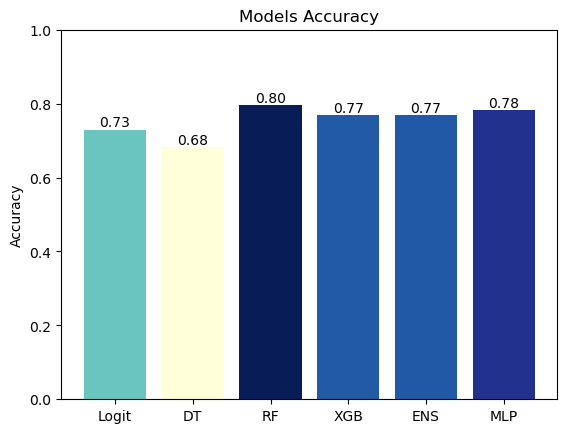

In [ ]:
models = list(metrics_all.keys())
accuracy = get_metric(metrics_all, 'acc')

# normalize accuracy values to [0,1] to highligh difference by color
norm = colors.Normalize(vmin=min(accuracy), vmax=max(accuracy))
cmap = plt.colormaps['YlGnBu']

bar_colors = cmap(norm(accuracy))

plt.figure()
bars = plt.bar(models, accuracy, color=bar_colors)

# value labels
for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        h,
        f'{h:.2f}',
        ha='center',
        va='bottom'
    )

plt.ylabel('Accuracy')
plt.title('Models Accuracy')
plt.ylim(0, 1)
plt.show()


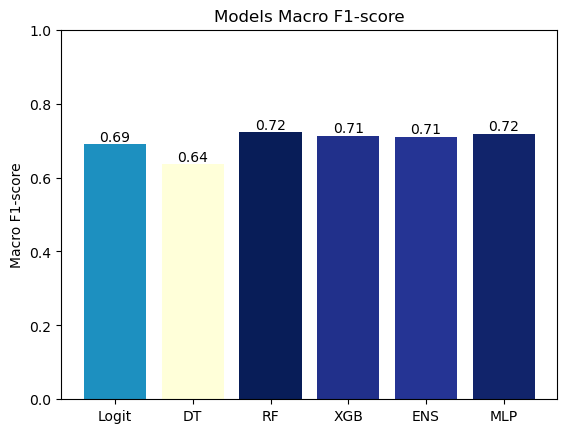

In [ ]:
macro_f1 = get_metric(metrics_all, 'macro_f1')

# normalize macro_f1 values to [0,1] to highligh difference by color
norm = colors.Normalize(vmin=min(macro_f1), vmax=max(macro_f1))
cmap = plt.colormaps['YlGnBu']

bar_colors = cmap(norm(macro_f1))

plt.figure()
bars = plt.bar(models, macro_f1, color=bar_colors)

# value labels
for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        h,
        f'{h:.2f}',
        ha='center', 
        va='bottom'
    )

plt.ylabel('Macro F1-score')
plt.title('Models Macro F1-score')
plt.ylim(0, 1)
plt.show()

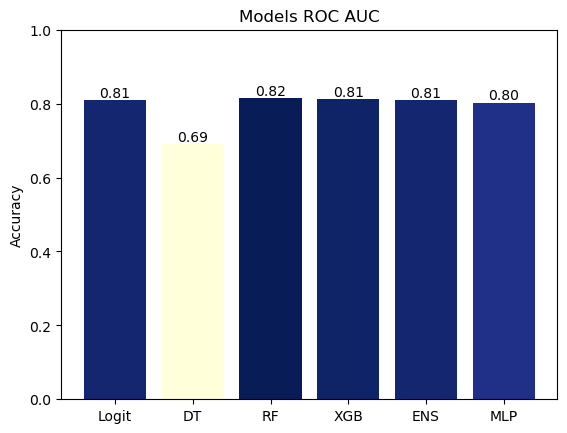

In [10]:
models_auc = list(auc_all.keys())

# fix scale if not identical for the models 
auc_values = np.array([
    v / 100 if v > 1 else v
    for v in auc_all.values()
])

# normalize accuracy values to [0,1] to highligh difference by color
norm = colors.Normalize(vmin=min(auc_values), vmax=max(auc_values))
cmap = plt.colormaps['YlGnBu']

bar_colors = cmap(norm(auc_values))

plt.figure()
bars =  plt.bar(models, auc_values, color=bar_colors)

# value labels
for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        h,
        f'{h:.2f}',
        ha='center',
        va='bottom'
    )

plt.ylabel('Accuracy')
plt.title('Models ROC AUC')
plt.ylim(0, 1)
plt.show()

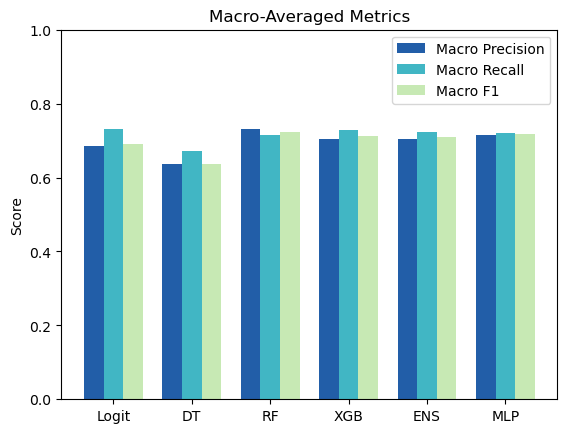

In [14]:
macro_prec = get_metric(metrics_all, 'macro_prec')  
macro_rec  = get_metric(metrics_all, 'macro_rec')
macro_f1   = get_metric(metrics_all, 'macro_f1')

x = np.arange(len(models))
width = 0.25

plt.figure()
plt.bar(x - width, macro_prec, width, label='Macro Precision', color ='#225ea8')
plt.bar(x, macro_rec, width, label='Macro Recall', color = '#41b6c4')
plt.bar(x + width, macro_f1, width, label='Macro F1', color = '#c7e9b4')

plt.xticks(x, models)
plt.ylabel('Score')
plt.title('Macro-Averaged Metrics')
plt.ylim(0, 1)
plt.legend()
plt.show()


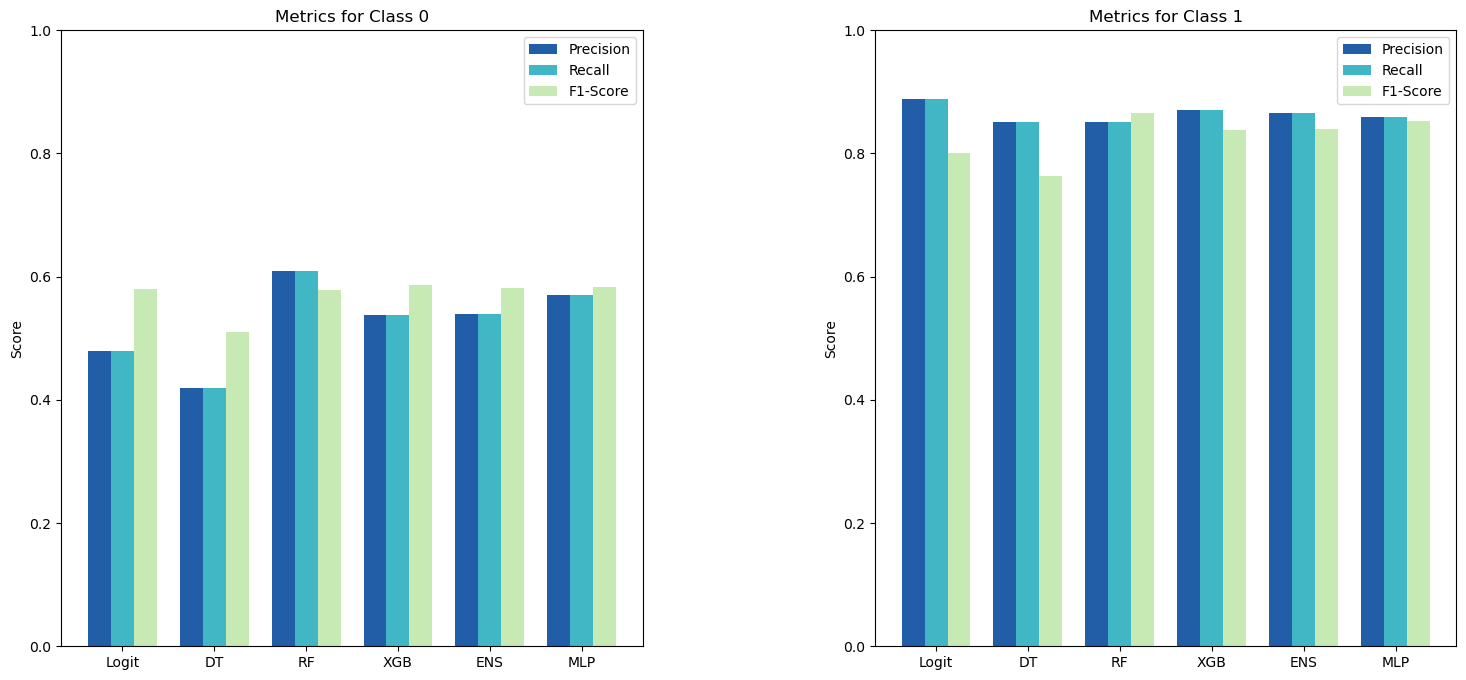

In [ ]:
models = list(metrics_all.keys())

# Metrcis for the class 0.0
prec_0 = get_metric(metrics_all, 'prec_0')
rec_0  = get_metric(metrics_all, 'rec_0')
f1_0   = get_metric(metrics_all, 'f1_0')

# Metrics for the class 1.0
prec_1 = get_metric(metrics_all, 'prec_1')
rec_1  = get_metric(metrics_all, 'rec_1')
f1_1   = get_metric(metrics_all, 'f1_1')

x = np.arange(len(models))
width = 0.25

fig, axes = plt.subplots(1, 2, figsize=(18,8))
fig.subplots_adjust(wspace=0.4)

# Class 0 plot
axes[0].bar(x - width, prec_0, width, label='Precision', color ='#225ea8')
axes[0].bar(x, rec_0, width, label='Recall', color = '#41b6c4')
axes[0].bar(x + width, f1_0, width, label='F1-Score', color = '#c7e9b4')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].set_ylabel('Score')
axes[0].set_title('Metrics for Class 0')
axes[0].set_ylim(0, 1)
axes[0].legend()


# Class 1 plot
axes[1].bar(x - width, prec_1, width, label='Precision', color ='#225ea8')
axes[1].bar(x, rec_1, width, label='Recall', color = '#41b6c4')
axes[1].bar(x + width, f1_1, width, label='F1-Score', color = '#c7e9b4')

axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].set_ylabel('Score')
axes[1].set_title('Metrics for Class 1')
axes[1].set_ylim(0, 1)
axes[1].legend()

plt.show()

Looking at the plots and precise data of the metrics, Random Forest (RF) is the clear statistical winner for overall metrics: <br>
- Accuracy is 0.7954 (highest) vs MLP (0.7827)<br>
- F1-Macro is 0.7219 (highest) vs. MLP (0.7184) <br>
- ROC AUC is 0.8155 (highest) vs. MLP (0.8024) <br>

Random Forest achieved the highest Test Accuracy and best ROC AUC (0.816). If our only goal was to predict the majority class "Agree" correctly, this would be our definite winner. Tree ensembles maximize mathematical "purity." Since the "Agree" class is 75% of the data, the easiest way to maximize purity is to focus heavily on correctly predicting "Agree".  It sacrificed the minority class. Its Recall for "Disagree" was 55%. It essentially decided that getting the minority group wrong was an acceptable cost for high overall accuracy. <br>

On the other side, MLP has a specific strength in minority Recall with 0.597 value, comparing with 0.551 for the Random Forest. This confirms the trade-off we discussed above. The Random Forest is generally "better" (more accurate, more precise), but the MLP is slightly more sensitive to the disagreement class. From that perspective, we can say that **MLP Neural Network is the best model**. The MLP is the model that better navigated the "Accuracy vs. Fairness" trade-off inherent in our imbalanced data.  It found significantly more of the "Disagree" group than the Random Forest (55%). In social science, missing a distinct minority opinion is a major failure [34]. The MLP avoided this. Unlike the Logistic Regression, which found the minority group by wildly guessing (low precision), the MLP maintained a solid precision (57%). Neural Networks are exceptional at finding non-linear interactions between features that don't have a simple hierarchy. While trees look for "split points" (e.g., Age > 50), the MLP likely found complex combinations of Identity + Culture + Economics that defined the minority group more accurately. <br>

Regarding the XGBoost model, it was incredibly precise (87%) when predicting the majority class. It rarely made false alarms. Despite tuning the scale_pos_weight, it struggled to find the minority class as effectively as the MLP. Gradient Boosting builds trees sequentially to fix errors, but it can sometimes "fix" errors by becoming too conservative, leading to more False Negatives (missing the minority class) than the MLP. <br>

The soft voting Ensemble is the most stable model with the lowest variance in cross-validation. It represents the "wisdom of crowds". However, an ensemble is an average. By averaging the high-recall MLP with the low-recall Random Forest, the final result was a "middle ground." It isn't as sensitive as the MLP, nor as accurate as the Random Forest. It was safe, but not a peak performer in either direction. <br>

Logistic Regression has the highest minority Recall (73%), but the lowest Precision (48%). Because it's limited to drawing a straight line (linear decision boundary) through complex data, it couldn't subtly separate the groups. It had to cast a "wide net" to catch the minority class, catching too many wrong items in the process. <br>

Decision Tree suffered from Overfitting/High Variance. A single tree tries to memorize the data. It created complex, specific rules for the depth 15 that worked on training data, but failed on the test set, leading to the lowest accuracy (68%).

### 6. Conclusion

Overall, machine learning models demonstrated meaningful predictive power despite the conceptual difficulty of the task. Linear Logistic Regression provided interpretable baseline results, showing that gender, education, and country context are the strongest predictors of agreement or disagreement. In particular, women, highly educated respondents, and individuals from more gender-egalitarian countries (like Sweden, Norway) were substantially more likely to disagree, while respondents from more traditional national contexts (like Serbia, Slovenia, Croatia, Poland) showed markedly higher agreement. These results highlight that attitudes toward protection norms are deeply embedded in macro-cultural environments rather than being purely individual opinions.<br>

Tree-based models refined this insight. The Decision Tree revealed that gender identity—measured through self-reported femininity—constitutes the primary divide in the population, effectively acting as a proxy for lived gender experience. Conditional on this split, religion, education, and national context further structured attitudes in distinct ways for men and women. Random Forest results showed that while gender identity is a powerful single split, stable prediction across the population relies more heavily on socio-economic and life-course factors such as education, age, work intensity, and religious practice. This indicates that traditional gender attitudes are reinforced through cumulative social positioning rather than any single identity marker.<br>

The XGBoost model emphasized this conclusion even more strongly by assigning the largest share of predictive importance to country indicators. Over 40% of the total importance was concentrated in national context variables, demonstrating that macro-level cultural norms dominate individual-level predictors in shaping views on gender protection. Individual characteristics such as education, gender identity, and religiosity remained important but were clearly conditioned by the broader cultural environment in which respondents live.<br>

From a predictive standpoint, all selected models performed well above chance despite the imbalance in the target variable. The Random Forest and XGBoost models achieved strong overall accuracy, while the Soft Voting Ensemble improved robustness and minority-class recall, making it more reliable for identifying disagreement. The MLP neural network achieved the highest overall balance, with strong F1-Macro and ROC-AUC scores and a particularly effective identification of the minority “disagree” class due to the use of class weighting. These results confirm that machine learning models can successfully distinguish between agreement and disagreement even for a socially complex and norm-laden attitude.<br>

In summary, our project demonstrates that machine learning classification models can reliably predict agreement with the statement “Women should be protected by men” using a limited set of psychosocial variables. Substantively, the findings show that this attitude is best understood as a product of macro-cultural context interacting with gender identity, education, and religion, rather than as a simple individual belief. Methodologically, the study illustrates the value of combining interpretable models with more flexible ensemble and neural approaches when analyzing social attitudes characterized by weak linear effects, strong interactions, and contextual heterogeneity.<br>

### Resources

1. ESS11 2023 Data Protocol, Edition 1.2 February 2023 [https://smlouvy.gov.cz/smlouva/soubor/32846151/P01E%20ESS11%202023%20Data%20Protocol.pdf?backlink=0t05o] <br>
2. "Machine Learning 1: classification methods" course materials by Michał Woźniak. University of Warsaw, Faculty of Economic Science. <br>
3. "Machine Learning 2: predictive models, deep learning, neural network" course materials by Ewa Weychert. University of Warsaw, Faculty of Economic Science. <br> 
4. Machine Learning Tutorial [https://www.geeksforgeeks.org/machine-learning/] <br>
5. How to Avoid Data Leakage When Imputing for Predictive Modeling [https://communities.sas.com/t5/SAS-Communities-Library/How-to-Avoid-Data-Leakage-When-Imputing-for-Predictive-Modeling/ta-p/911876]<br>
6. Scikit-learn: Common pitfalls and recommended practices   [https://scikit-learn.org/stable/common_pitfalls.html] <br>
7. Scikit-learn: Logistic Regression [https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html] <br>
8. Understanding Feature Importance in Logistic Regression Models  [https://www.geeksforgeeks.org/machine-learning/understanding-feature-importance-in-logistic-regression-models/] <br>
9. Understanding Accuracy, Precision, Recall and F1 Score  [https://medium.com/@arnanbonny/004-understanding-accuracy-precision-recall-and-f1-score-3bf026dc619c] <br>
10. Grid Search for Decisiion Tree [https://medium.com/biased-algorithms/grid-search-for-decision-tree-ababbfb89833] <br>
11. Decision tree, implementation in python [https://www.geeksforgeeks.org/machine-learning/decision-tree-implementation-python/] <br>
12. Is it Necessary For Feature Scaling in Tree-Based Models? [https://www.nb-data.com/p/is-it-necessary-for-feature-scaling] <br>
13. How to tune a Decision Tree in Hyperparameter tuning  [https://www.geeksforgeeks.org/machine-learning/how-to-tune-a-decision-tree-in-hyperparameter-tuning/]<br>
14. A Simple Explanation of Giny Impurity [https://victorzhou.com/blog/gini-impurity/]<br>
15. Scikit-learn: Decision Tree [https://scikit-learn.org/stable/modules/tree.html]<br>
16. Hyperparameters of Random Forest Classifier [https://www.geeksforgeeks.org/machine-learning/hyperparameters-of-random-forest-classifier/] <br>
17. Scikit-learn: Random Forest Classifier [https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html] <br>
18. Scikit-learn: OOB Errors for Random Forest [https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#sphx-glr-auto-examples-ensemble-plot-ensemble-oob-py] <br>
19. OOB Errors for Random Forest in Scikit Learn [https://www.geeksforgeeks.org/machine-learning/oob-errors-for-random-forests-in-scikit-learn/] <br>
20. XGBoost Tutorials: Notes on Parameter Tuning [https://xgboost.readthedocs.io/en/release_0.90/tutorials/param_tuning.html]<br>
21. XGBoost Parameters [https://xgboost.readthedocs.io/en/release_0.90/parameter.html] <br>
22. XGBoost Parameters [https://www.geeksforgeeks.org/machine-learning/xgboost-parameters/] <br>
23. Handling Imbalanced Datasets with XGBoost: Optimizing Model Performance with Smart Parameter Tuning [https://medium.com/@mate.voros1998/handling-imbalanced-datasets-with-xgboost-optimizing-model-performance-with-smart-parameter-tuning-18568c7783cf] <br>
24. XGBoost for Imbalanced Classification [https://xgboosting.com/xgboost-for-imbalanced-classification/] <br>
25. XGBoost "scale_pos_weight" vs "sample_weight" for Imbalanced Classification [https://xgboosting.com/xgboost-scale_pos_weight-vs-sample_weight-for-imbalanced-classification/] <br>
26. The importance of feature scaling in machine learning: Logistic regression for example [https://medium.com/@jairiidriss/the-importance-of-feature-scaling-in-machine-learning-logistic-regression-for-example-b3068f8d3441] <br>
27. Day 8: Ensemble Methods in ML — Voting Algorithm [https://medium.com/@lakshmi.m.kanthi/day-8-ensemble-methods-in-ml-voting-algorithm-9e17e516426b]<br>
28. How to Develop Voting Ensembles With Python [https://machinelearningmastery.com/voting-ensembles-with-python/] <br>
29. Multilayer Perceptrons in Machine Learning: A Comprehensive Guide [https://www.datacamp.com/tutorial/multilayer-perceptrons-in-machine-learning] <br>
30. Stackoverflow: Classification with imbalanced dataset using Multi Layer Perceptrons [https://stackoverflow.com/questions/46759662/classification-with-imbalanced-dataset-using-multi-layer-perceptrons] <br>
31. Scikit-learn: compute_class_weight [https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html] <br>
32. Stackoverflow: 'super' object has no attribute sklearn_tags [https://stackoverflow.com/questions/79290968/super-object-has-no-attribute-sklearn-tags] <br>
33. Introduction to the Keras Tuner [https://www.tensorflow.org/tutorials/keras/keras_tuner] <br>
34. Majority and minority [https://www.ebsco.com/research-starters/social-sciences-and-humanities/majority-and-minority] <br>